# Code for "Mapping the landscape of magnetic field effects on neural repair: a systematic review, mathematical model, and meta-analysis" 
### Written by: Meghan McGraw and Gabrielle Gilmer

# Imports
### Import packages into Python

In [1]:

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
import pandas as pd
import seaborn as sns 
import os
import random
import statsmodels.api as sm
import csv

# 3D Plot
### Input: Excel/ CSV data file
### Output: 3D plot of SMD versus 2 independent variables
### Return value:  matrix of mag, freq, SMD, SDpool, characteristic, cell_type 

### This function generates a 3D plot of the SMD and two independent variables for a given regenerative characteristic.

In [2]:

def plot_raw_data(file):
    #  Import data from CSV
    dat = pd.read_csv(file, index_col = None)
    dataMat = pd.DataFrame(dat, columns= ['Title', 'CellCategory', 'SpecificOutcomeVariable','SampleSize', 'Magnitudge', 'Freq', 'TotalTimeExposed', 'pertimeExposed', 'SMD', 'Sdpool'])
    
    # sort -- in order for the ODE solver to run the data on a certain independent variable, the data needs to be sorted
    #  in ascending/ descending order based on the independent variable
    if choice == 'magnitude':
        dataMat = dataMat.sort_values('Magnitudge')
        x = dataMat.Magnitudge
        xl = 'Magnitude (mT)'
    elif choice == 'frequency':
        dataMat = dataMat.sort_values('Freq')
        xl = 'Frequency (Hz)'
        x= dataMat.Freq
    elif choice == 'total_time':
        dataMat = dataMat.sort_values('TotalTimeExposed')
        x= dataMat.TotalTimeExposed
        xl = 'Total Time Exposed (hours)'
    else:
        dataMat = dataMat.sort_values('pertimeExposed')
        x = dataMat.pertimeExposed
        xl = 'Percent Time Exposed (%)'
    
    # split up into different columns
    Title = dataMat.Title
    mag = dataMat.Magnitudge
    freq = dataMat.Freq
    time = dataMat.TotalTimeExposed
    percent = dataMat.pertimeExposed
    SMD = dataMat.SMD
    SDpool = dataMat.Sdpool

    # Plot raw data -- 3D plots -- generate all possible 2 independent variable combinations
    # SMD as a function of 2 independent variables
    
    choices = ['magnitude', 'frequency', 'total_time', 'percent']
    choices.remove(choice)
    
    for c in choices:
        fig = plt.figure(figsize=(9, 9))
        plt.rcParams.update({'font.size': 14})
        ax = plt.axes(projection='3d')
        
        if c == 'magnitude':
            y = mag
            yl = 'Magnitude (mT)'
        elif c == 'frequency':
            y = freq
            yl = 'Frequency (Hz)'
        elif c == 'total_time':
            y = time
            yl = 'Total Time Exposed (hours)'
        else:
            y = percent
            yl = 'Percent Time Exposed (%)'
        
        zline = SMD
        xline = x
        yline = y
        ax.plot3D(xline, yline, zline, 'ro')
        ax.set_xlabel(xl)
        ax.set_ylabel(yl)

        ax.set_zlabel('SMD')

        #add title
        plt.title(name + '_' + choice + '_' + c + " Raw Data")

        plt.savefig('Final_data/3D_Plot/' + name + '_' + choice + '_' + c + '3D_Plot.png', dpi=300, bbox_inches='tight');

    #return pertinent data
    return [mag, freq, time, percent, SMD, SDpool]
    

# Linear/nonlinear regression model
### Input: x_value (independent variable values of magnitude, frequency, total time exposed, or percent time exposed), y_value (SMD), fit
### Return: slope and y-intercept (linear) or polynomial and linear coefficients (polynomial)

### This function uses numpy polyfit to generate first guess slope and y-intercept (linear) or the polynomial and linear coefficients (polynomial) for the mathematical modeling

In [3]:
def regression(x_value, y_value, fit):
    x_value = np.array(x_value.tolist())
    y_value = np.array(y_value.tolist())
    fig5, ax5 = plt.subplots()
    ax5.plot(x_value, y_value,'ro',label='Data for ' + name)
    
    if fit == 'Polynomial':
        p = np.polyfit(x_value, y_value, 2)
    else:
        p = np.polyfit(x_value, y_value, 1)     
    ax5.plot(x_value, np.polyval(p, x_value),color='blue',label='Best Fit for ' + name)
    plt.title('A = ' + str(round(p[0], 7)) + " B = " + str(round(p[1], 7)))

    ax5.legend()

    fig5.savefig('Final_data/Regression/' + name + "_" + choice + "_" + fit +\
            '_Regression.png', dpi=300, bbox_inches='tight');
    
    #a and b values returned
    print("a:")
    print(p[0])
    print("b:")
    print(p[1])
    return p

# Auxillary Functions
### Stepwise differential equation solver and root-mean-square error functions

In [4]:
# set up model
def dSMDdFq(SMD, fq, a, b):
    dSMDdFq = a*fq + b
    return dSMDdFq

#root mean square error

# define RMSE 
# steps
def RMSE(params):
    a, b = params;
    ODE_output = odeint(dSMDdFq, SMD_0, steps, args = (a,b));
    err = ExpData -ODE_output
    SSE = np.sum(err**2)
    RMSE = np.sqrt(SSE)
    return RMSE


# Run model function

### Input: mag, freq, time, percent, SMD, SDpool, fit (linear/polynomial)
### Returns a and b matrix, fit

### Produces 4 plots after running 10,000 trials to guess the a and b values of the data, showing the distribution of a, b, and RMSE values across trials

In [5]:

def run_model(mag, freq, time, percent, SMD, SDpool, fit):
    
    print(name, choice, fit)
    # Defines the size of the vector
    sizeSMD = len(SMD)
    # Defines the index size
    index = sizeSMD
    # Sets initial value
    global SMD_0
    SMD_0 = 0

    # Pulls dosage values to evaluate 
    # evaluate based on which independent variable is chosen
    global steps
    if choice == 'frequency':
        steps = freq
    elif choice == 'magnitude':
        steps = mag
    elif choice == 'total_time': 
        steps= time
    else:
        steps= percent
    
    
    # Sets initial guesses based on trendline model from Excel
    if fit == "Polynomial":
        p0 = [a_guess_poly, b_guess_poly]
    else:
        p0 = [a_guess_linear, b_guess_linear]
        
    # sets counter equal to zero
    f = 0

    # Number of values to be generated for each data point
    nVal = 100
    # Generates a vector of the different values of a, b, and RMSE generated by the simulation
    a = np.zeros(num_trials+1) 
    b = np.zeros(num_trials+1) 
    RMSE_val = np.zeros(num_trials+1) 
    
    # generates a figure for the simulations to be plotted on
    fig1, ax1 = plt.subplots()

    plt.rcParams.update({'font.size': 14});

    # labeling purposes
    if choice == 'frequency':
        s = "Frequency (Hz)"
    elif choice == 'magnitude':
        s = "Magnitude (mT)"
    elif choice == 'total_time': 
        s = 'Total Time Exposed (hours)'
    else:
        s = 'Percent Time Exposed (%)'    

    ax1.set_xlabel(s)
    
    
    ax1.set_ylabel("SMD of " + name + ' (' + fit + ")")

    # Simulates using different initial conditions
    for j in np.arange(1, num_trials,1):
        # Generates ExpData vector
        global ExpData
        ExpData = np.arange(0,index,1)
        # Sets iteration markers
        m = 0
        for x in np.arange(0,index,1):
            # Generates a normal distribution based on the SMD and SD from that specific data point
            RandGen = np.random.normal(SMD[m], SDpool[m], nVal)
            # Randomly pulls a value from that normal distirbution to input into model
            randCho = random.choice(RandGen)
            # Assigns random value into experimental data
            ExpData[m] = randCho
            # Iterates m 
            m = m + 1


        # Minimizes RMSE uses initial data
        sol = minimize(RMSE, p0);
        # Enters generated value into the vector to track all possible a and b values from simulation
        if fit == "Polynomial":
            a_temp = sol.x[0]
        else:
            a_temp = 0
        b_temp = sol.x[1]
        # Generates model data based on a and b values
        modelData = odeint(dSMDdFq, SMD_0, steps, args = (a_temp,b_temp));          
        # Stores a, b, and RMSE value 
        a[f] = a_temp;
        b[f] = b_temp;
        RMSE_val[f] = sol.fun
        # Increases counter
        f = f+1
        # Plots simulation
        ax1.plot(steps, modelData, 'b-')
    
    #saves models as a figure to folder 
    fig1.savefig('Final_data/Simulation_Model/' + name + "_" + choice + "_" + fit + '_SimModel.png', dpi=300, bbox_inches='tight');


    # Plots generated a values
    fig2, ax2 = plt.subplots()
    ax2.hist(a, bins = 50);
    plt.rcParams.update({'font.size': 14});
    plt.title("Distribution of a values " + name + ", " + choice + ' (' + fit + ")")
    ax2.set_xlabel("a")
    ax2.set_ylabel("Counts")
    
    fig2.savefig('Final_data/A_Value/' + name + "_" + choice + "_" + fit + '_SimAValue.png', dpi=300, bbox_inches='tight');
    
    # Plots generated b values
    fig3, ax3 = plt.subplots()
    ax3.hist(b,bins = 50);
    plt.rcParams.update({'font.size': 14});
    plt.title("Distribution of b values " + name + ", " + choice + ' (' + fit + ")")
    ax3.set_xlabel("b")
    ax3.set_ylabel("Counts")
    
    fig3.savefig('Final_data/B_Value/' + name + "_" + choice + "_" + fit + '_SimBValue.png', dpi=300, bbox_inches='tight');
    
    # Plots generated RMSE values
    fig4, ax4 = plt.subplots()
    ax4.hist(RMSE_val,bins = 50);
    plt.rcParams.update({'font.size': 14});
    plt.title("Distribution of RMSE values " + name + ", " + choice + ' (' + fit + ")")
    ax4.set_xlabel("RMSE")
    ax4.set_ylabel("Counts")
    
    fig4.savefig('Final_data/RMSE_Value/' + name + "_" + choice + "_" + fit + '_SimRMSEValue.png', dpi=300, bbox_inches='tight');

    with open('Final_data/A_matrix/' + name + "_" + choice + "_" + fit +'.csv', 'w', newline='') as csv_1:
      csv_out = csv.writer(csv_1)
      csv_out.writerows([a[index]] for index in range(0, len(a)))    
 
    with open('Final_data/B_matrix/' + name + "_" + choice + "_" + fit +'.csv', 'w', newline='') as csv_2:
      csv_out = csv.writer(csv_2)
      csv_out.writerows([b[index]] for index in range(0, len(b)))    
        
    return [a, b, fit]



# P-value function

### Input: a, b, title (characteristics of dataset from filename), fit
### Output: values and probabilities of a and b

### Calculates the probability of the a and b values actually being 0 from the simulation-produced a and b values

In [6]:


def calc_p_value(a, b, title, fit):
    print(title)
    # Print the average value for both paramters
    a_avg = sum(a.sum())/len(a)
    b_avg = sum(b.sum())/len(b)
    
    print('The average value for the a parameter is %.4f.' % a_avg)
    print('The average value for the b parameter is %.4f.' % b_avg)
    
    # Calculate the p value for a 
    f = 0
    n = 0
    sizeA = len(a)-1
    for j in np.arange(1,sizeA,1):
        if a.iloc[f][0] >= 0:
            n = n +1
        f = f+1

    a_pvalue = (sizeA-n)/sizeA
    
    #modification--for value at 0, probability is 1
    #if negative, the value needs to be inverted
    if a_avg<0:
        a_pvalue = 1 - a_pvalue

    if a_avg == 0:
        a_pvalue = 1

    # Calculate p value for b
    g = 0
    m= 0
    sizeB = len(b)-1
    for k in np.arange(1,sizeB,1):
        if b.iloc[g][0] >= 0:
            m = m+1
        g = g+1

    #modification
    b_pvalue = (sizeB - m)/sizeB
    
    #modification
    if b_avg<0:
        b_pvalue = 1 - b_pvalue
        
    if b_avg == 0:
        b_pvalue = 1
    
    
    # Print both p values
    print('The p-value for the a parameter is %.4f.' % a_pvalue)
    print('The p-value for the b parameter is %.4f.' % b_pvalue)

    
    #make 2D list, exported as CSV file containing the a, b, and p values
    lst=[['', 'average value', 'p-value'], ['a', a_avg, a_pvalue], ['b', b_avg, b_pvalue]]
    #print(lst)

    with open('Final_data/p_values/' + title + '_' + fit +'.csv', 'w', newline='') as csv_1:
        csvWriter = csv.writer(csv_1,delimiter=',')
        csvWriter.writerows(lst)
    return [a_pvalue, b_pvalue, a_avg, b_avg]



# Call functions appropriately
### plot_raw_data(), regression(), run_model()
### Iterate through all datasheets and independent variables to produce plots and calculations aforementioned 

a:
6.117853903605512e-05
b:
-0.0014733007441670443
Proliferation frequency Polynomial
a:
0.007104961274877871
b:
1.412203843346335
Proliferation frequency Linear
a:
-2.8741712924567723e-05
b:
0.01009976707969968
Proliferation total_time Polynomial


<ipython-input-5-b8bd61c82b24>:130: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig4, ax4 = plt.subplots()


a:
-0.00018515520667151397
b:
1.7415373362685553
Proliferation total_time Linear
a:
8.893052299099923
b:
-9.122849327889188
Proliferation percent Polynomial
a:
0.6573715007115367
b:
1.4082848489172644
Proliferation percent Linear


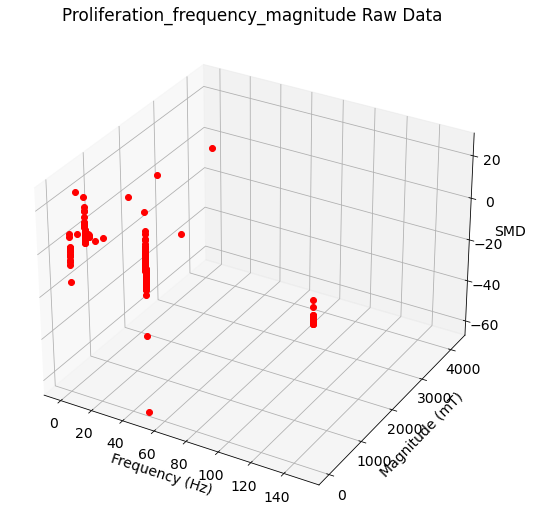

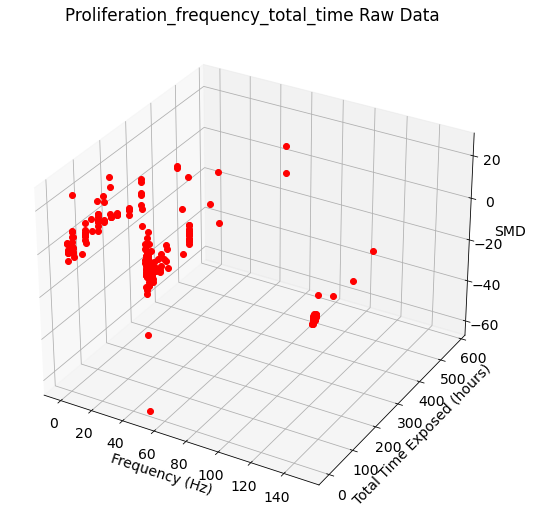

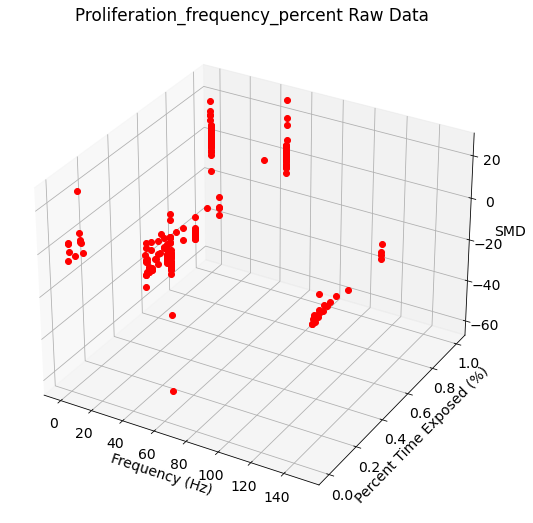

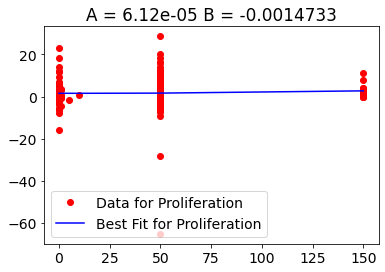

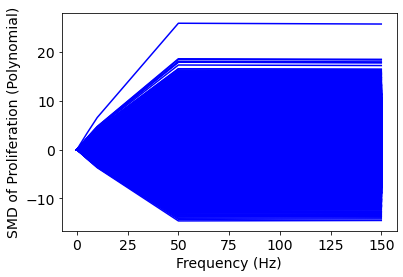

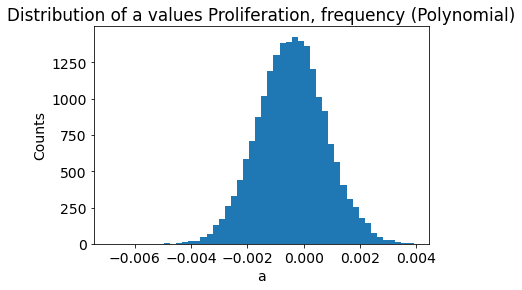

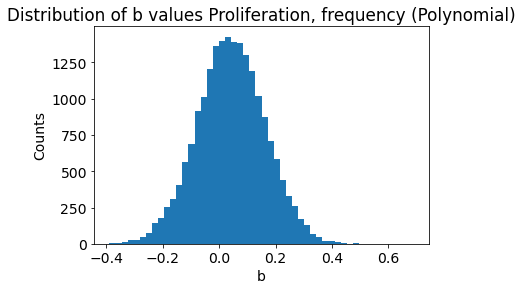

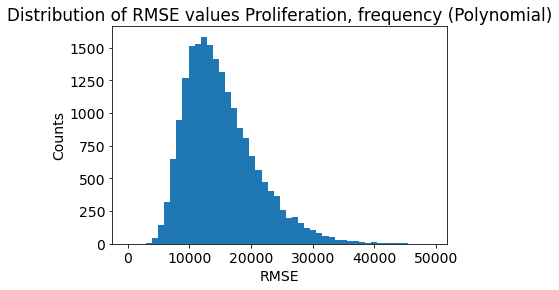

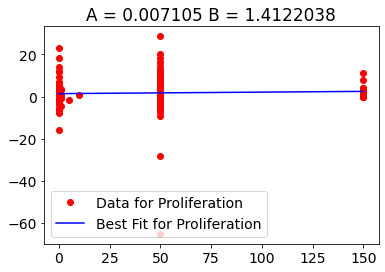

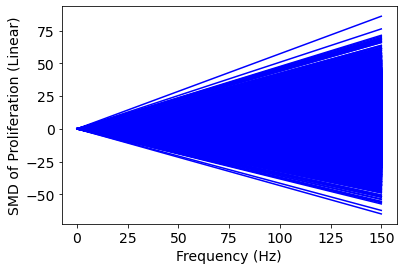

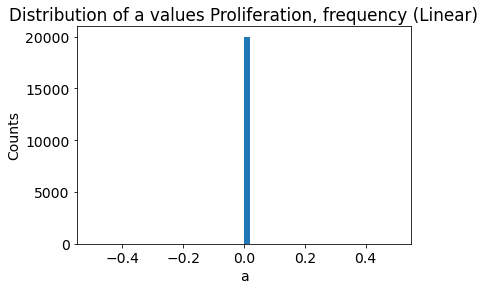

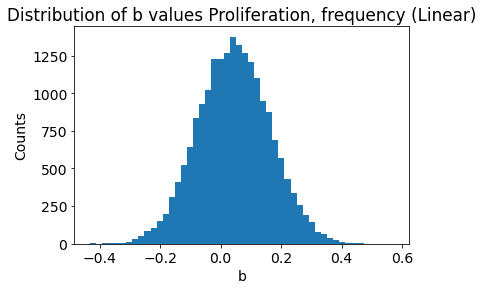

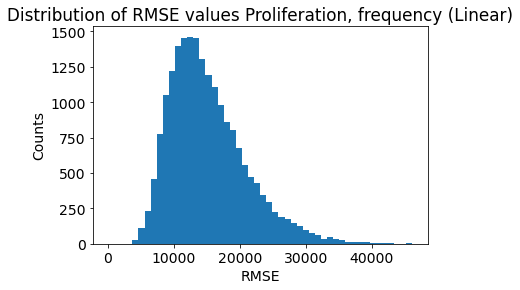

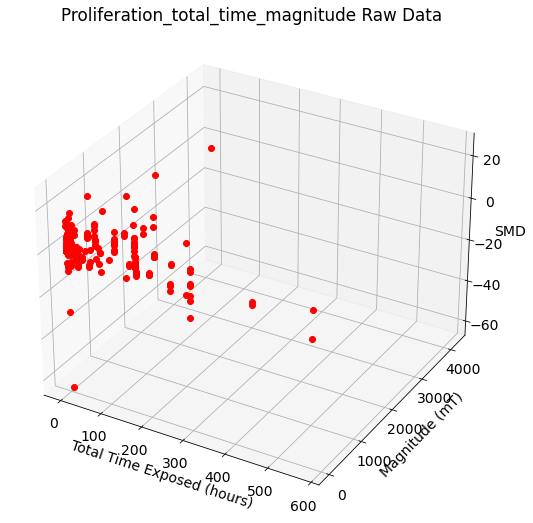

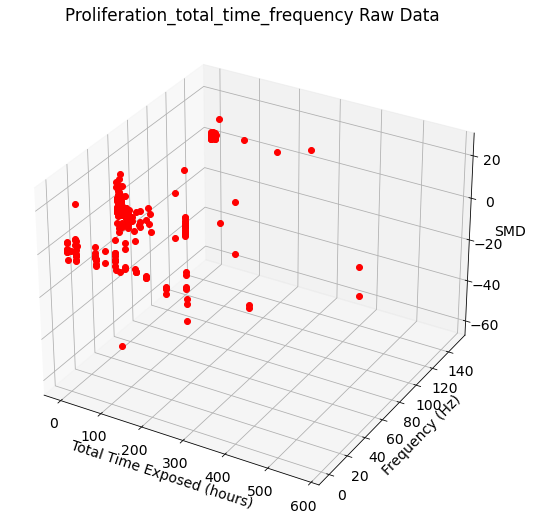

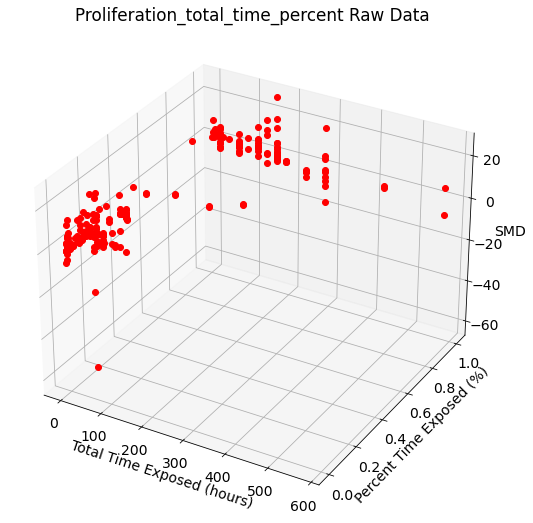

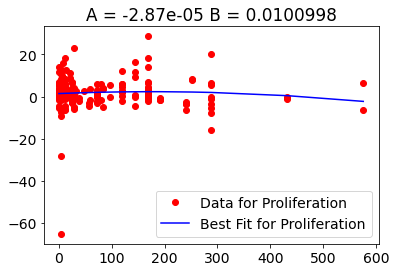

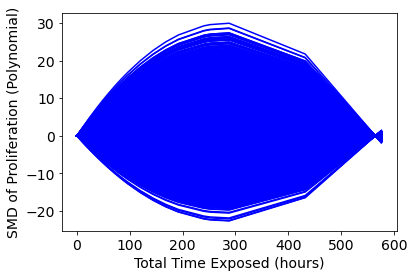

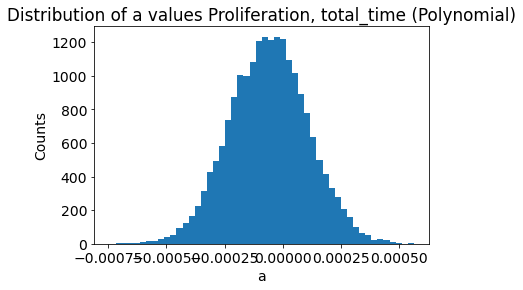

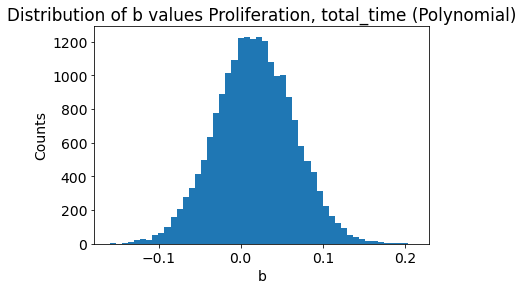

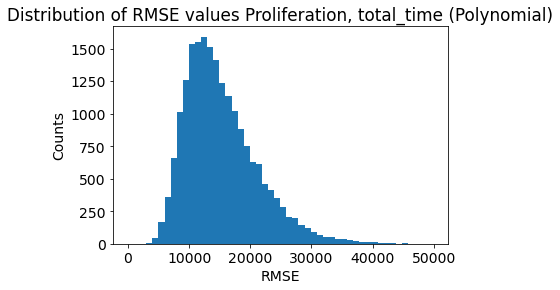

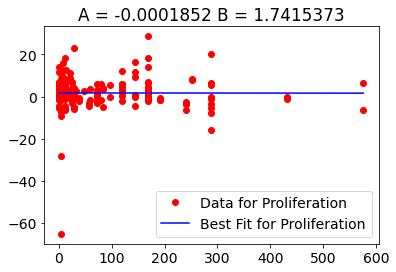

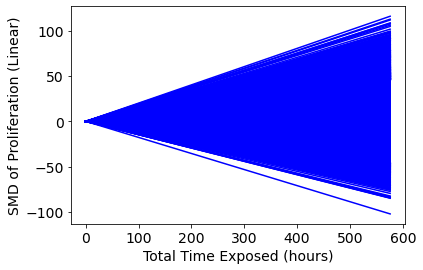

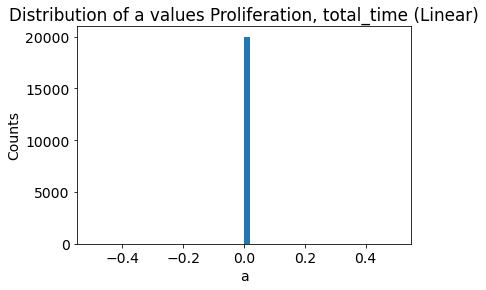

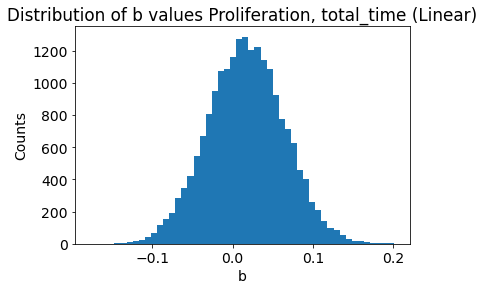

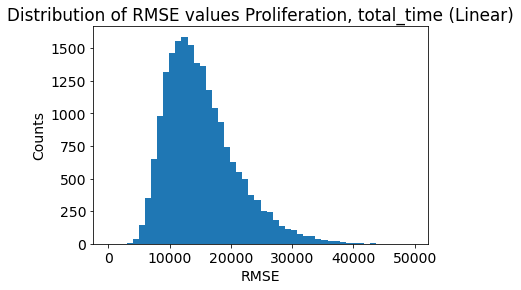

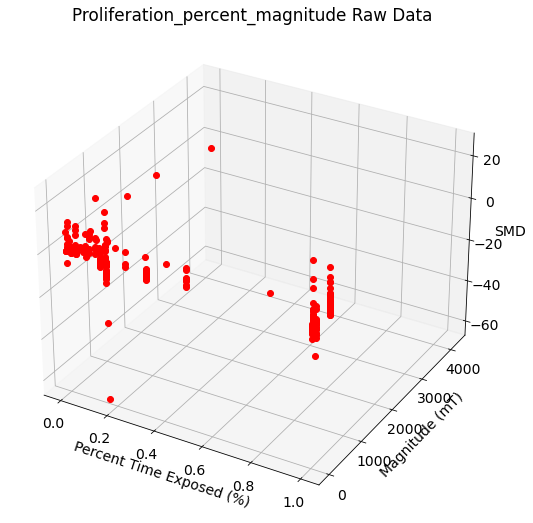

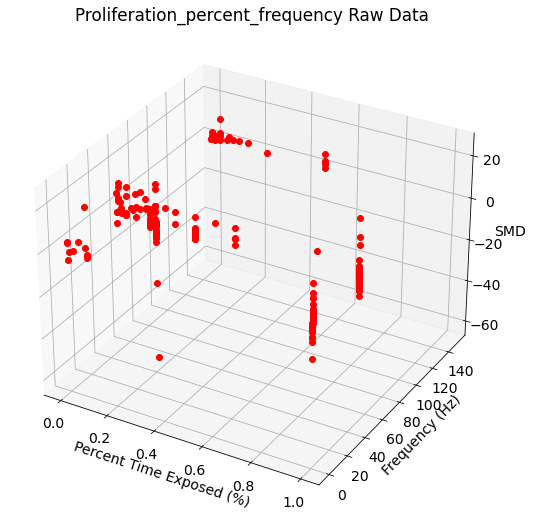

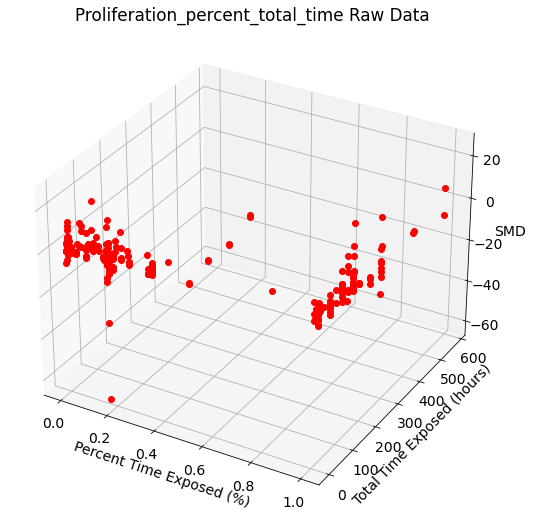

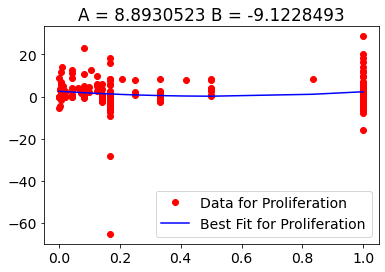

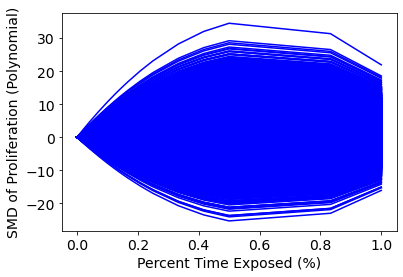

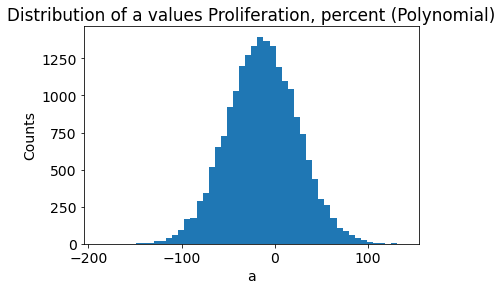

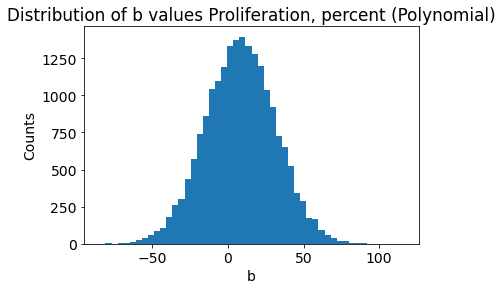

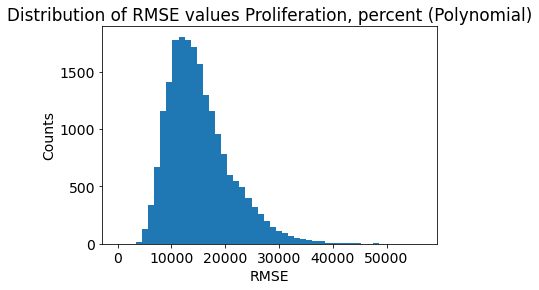

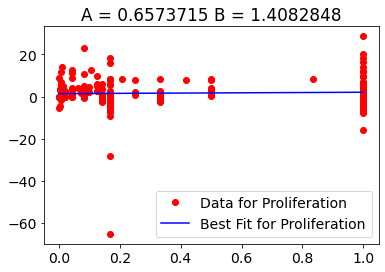

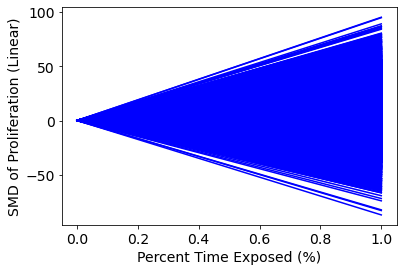

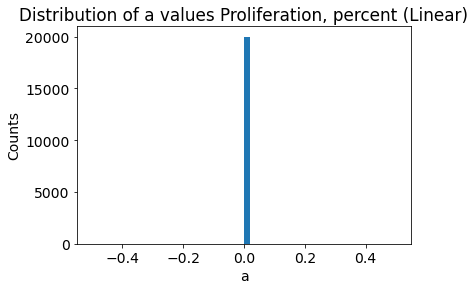

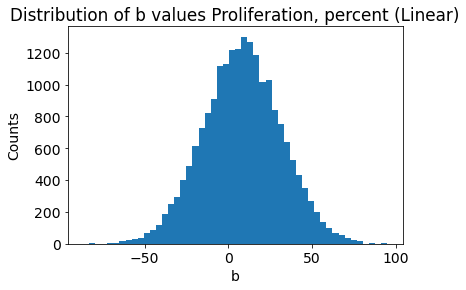

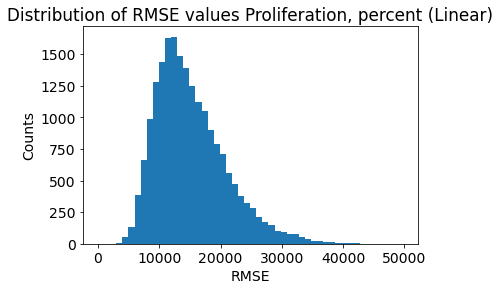

In [7]:

names = ['Astrocyte', 'Neuron', 'Oligodendrocyte', 'Differentiation', 'Growth', 'Viability', 'Proliferation']
cho = ['magnitude', 'frequency', 'total_time','percent']


#iterate through each category
for name in names:
    # iterate through each independent variables
    for c in cho:
        file_name = name
        num_trials = 20000
        choice = c

        #generates 3D plot
        file = 'Data/' + file_name+".csv"

        #generates 3D plot
        x = plot_raw_data(file)

        #guess a, b, generates a, b, and RMSE plots

        #find a and b guess values, generates regression coefficients and plot (poly)

        if choice == 'frequency':
            r = regression(x[1], x[4], 'Polynomial')
        elif choice == 'magnitude':
            r= regression(x[0], x[4], 'Polynomial')
        elif choice == 'total_time':
            r= regression(x[2], x[4], 'Polynomial')
        elif choice == 'percent':
            r= regression(x[3], x[4], 'Polynomial')
        a_guess_poly = r[0]
        b_guess_poly = r[1]

        y = run_model(x[0], x[1], x[2], x[3], x[4], x[5], 'Polynomial')


        #guess a, b, generates a, b, and RMSE plots

        #find a and b guess values, generates regression coefficients and plot (linear)
        if choice == 'frequency':
            r = regression(x[1], x[4], 'Linear')
        elif choice == 'magnitude':
            r= regression(x[0], x[4], 'Linear')
        elif choice == 'total_time':
            r= regression(x[2], x[4], 'Linear')
        elif choice == 'percent':
            r= regression(x[3], x[4], 'Linear')
        a_guess_poly = r[0]
        a_guess_linear = r[0]
        b_guess_linear = r[1]

        #guess a, b, generates a, b, and RMSE plots
        z = run_model(x[0], x[1], x[2], x[3], x[4], x[5], 'Linear')



# Call functions appropriately (p-value calculation)
### Iterate through all of the a and b values from the simulations to generate an average value and probability of being 0

In [8]:

# filepath
filepath_a= 'Final_data/A_matrix/'
filepath_b= 'Final_data/B_matrix/'

#make starting list for collecting all significant data
significant = [['Analysis', "Choice", 'A/B', 'Fit', "Probability", "Value"]]

#A_matrix properties
for filename in os.listdir(filepath_a):
    if 'csv' in filename:
        
        #extraction of names
        f = os.path.join(filepath_a, filename)

        #extract type of analysis--A
        x = f.find("_matrix")
        if 'Linear' in f:
            y = f.find('_Linear')
            fit = "Linear"
        else:
            y = f.find('_Polynomial')
            fit = 'Polynomial'
         
        title = f[x + 8 : y]
        
        a= pd.read_csv(f, index_col = None)
        
        f_b = filepath_b + filename
        
        b= pd.read_csv(f_b, index_col = None)

        #actually run the function
        result = calc_p_value(a, b, title, fit)
        
        #more labeling for the final spreadsheet
        if 'magnitude' in f:
            ch = 'magnitude'
        elif 'frequency' in f:
            ch = 'frequency'
        elif 'percent' in f:
            ch = 'percent'
        else:
            ch = 'total time'
            
        # if the results are significant, add it to the final spreadsheet
        if result[0] < 0.05:
            significant.append([title] + [ch] + ["A"] + [fit] + [result[0]] + [result[2]])
        if result[1] < 0.05:
            significant.append([title] + [ch] + ["B"]+ [fit] + [result[1]] + [result[3]])

#write the accumulated file
with open("Significant_values.csv", "w", newline='') as f:
    writer = csv.writer(f,delimiter=',')
    writer.writerows(significant)


Astrocyte_frequency
The average value for the a parameter is 0.0000.
The average value for the b parameter is -48.6247.
The p-value for the a parameter is 1.0000.
The p-value for the b parameter is 0.4951.
Astrocyte_frequency
The average value for the a parameter is 0.5303.
The average value for the b parameter is -13.2845.
The p-value for the a parameter is 0.4978.
The p-value for the b parameter is 0.4978.
Astrocyte_magnitude
The average value for the a parameter is 0.0000.
The average value for the b parameter is -0.0009.
The p-value for the a parameter is 1.0000.
The p-value for the b parameter is 0.4966.
Astrocyte_magnitude
The average value for the a parameter is 0.0000.
The average value for the b parameter is -0.0019.
The p-value for the a parameter is 0.4959.
The p-value for the b parameter is 0.4957.
Astrocyte_percent
The average value for the a parameter is 0.0000.
The average value for the b parameter is -12.7800.
The p-value for the a parameter is 1.0000.
The p-value for t

The p-value for the a parameter is 1.0000.
The p-value for the b parameter is 0.3631.
Proliferation_total_time
The average value for the a parameter is -0.0001.
The average value for the b parameter is 0.0170.
The p-value for the a parameter is 0.3638.
The p-value for the b parameter is 0.3638.
Viability_frequency
The average value for the a parameter is 0.0000.
The average value for the b parameter is 0.1110.
The p-value for the a parameter is 1.0000.
The p-value for the b parameter is 0.0001.
Viability_frequency
The average value for the a parameter is -0.0011.
The average value for the b parameter is 0.1109.
The p-value for the a parameter is 0.0000.
The p-value for the b parameter is 0.0001.
Viability_magnitude
The average value for the a parameter is 0.0000.
The average value for the b parameter is 0.0079.
The p-value for the a parameter is 1.0000.
The p-value for the b parameter is 0.0001.
Viability_magnitude
The average value for the a parameter is -0.0000.
The average value for

# Raw data extraction

### inputs:
### new_path-- Original data matrices

### outputs:
### SMD-- difference between mean and a value
### SDPool--variance from the mean and a value

### This section helps to reextract data from the original data matrices

In [9]:

def raw_data(new_path):
    #set up data for usage in the ODE, unique for every file
    
    #index
    global index
    index = len(pd.read_csv(new_path))

    #open file, extract data
    #get magnitude or frequency data
    #also extract SMD, SMD_pool
    dat = pd.read_csv(new_path, index_col = None)
    dataMat = pd.DataFrame(dat, columns= ['Title', 'CellCategory', 'SpecificOutcomeVariable','SampleSize', 'Magnitudge', 'Freq', 'TotalTimeExposed', 'pertimeExposed', 'SMD', 'Sdpool'])
    
    #data_of_interest
    #SMD
    #SD_pool
    global steps
    if 'magnitude' in new_path:
        dataMat = dataMat.sort_values('Magnitudge')
        steps = dataMat.Magnitudge
    elif 'frequency' in new_path:
        dataMat = dataMat.sort_values('Freq')
        steps = dataMat.Freq
    elif 'percent' in new_path:
        dataMat = dataMat.sort_values('pertimeExposed')
        steps = dataMat.pertimeExposed
    else:
        dataMat = dataMat.sort_values('TotalTimeExposed')
        steps = dataMat.TotalTimeExposed
        
    global SMD
    SMD = dataMat.SMD
    global SDpool
    SDpool = dataMat.Sdpool


# ExpDataGen
### Generate sample data based on the parameters from before for each simulation

In [10]:


def ExpDataGen():
    nVal = 100
    # Generates ExpData vector--used in ODE solver
    global ExpData
    ExpData = np.arange(0,index,1)
    # Sets iteration markers
    m = 0
    for x in np.arange(0,index,1):
        # Generates a normal distribution based on the SMD and SD from that specific data point
        RandGen = np.random.normal(SMD[m], SDpool[m], nVal)
        # Randomly pulls a value from that normal distirbution to input into model
        randCho = random.choice(RandGen)
        # Assigns random value into experimental data
        global SMD_0
        SMD_0 = randCho
        ExpData[m] = randCho
        # Iterates m 
        m = m + 1

# RMSE_vs_a_b
### Input: a, b (based on the simulations)
### Outputs: 3D plot of RMSE versus varied a and b values, RMSE versus varied a, and RMSE versus varied b
### shape of changes of RMSE due to a and b noted (polynomial, linear)


In [11]:

def RMSE_vs_a_b(a, b):
    # Creates vectors of possible a and b values based on above simulations
    a_poss = np.linspace(a * 0.1, a * 2,10)
    b_poss = np.linspace(b * 0.1, b * 2, 10)

    #extract data file
    ng = group.find('_')
    if group[ng + 1] == 'd':
        new_group = group[: ng + 5]
    elif group[ng + 1] == 'u':
        new_group = group[: ng + 3]
    else:
        new_group = group[: ng]
    new_path = 'Data/' + new_group + '.csv'

    #get the parsed data
    raw_data(new_path)
    
    ExpDataGen()
    
    #need to get the aliasing correct on the graphs in order to save them
    # Calculates RMSE for each possible a and b value
    fig = plt.figure(figsize=(9, 9))
    plt.rcParams.update({'font.size': 14})
    ax = plt.axes(projection='3d')
    ax.set_xlabel('A Value')
    ax.set_ylabel("B Value")
    ax.set_zlabel("RMSE")
    plt.title("3D plot of " + group + " (" + choice+ ")")
    
    #set colors for the different datasets to see the contouring over time
    colors = ['red', 'orangered', 'orange', 'yellow', 'greenyellow', 'green', 'blue', 'purple', 'pink', 'brown', 'black']
    
    #reset index every time
    ind = 0
    for a in a_poss:
        fill = colors[ind]
        ind += 1
        for b in b_poss:
            RMSE_val = RMSE([a,b])
            ax.plot3D(a,b, -RMSE_val, 'co', color = fill)
    fig.savefig('Final_data/Final_data_sensitivity/3D_Plots/' + group + "_" + choice + '_3DPlot.png', dpi=300, bbox_inches='tight');
    
    ind = 0
    # Generates a 2D figure for a versus RMSE to be plotted for easier visualization
    fig2, ax2 = plt.subplots(figsize=(9, 9))
    plt.rcParams.update({'font.size': 14})
    for a in a_poss:
        fill = colors[ind]
        ind += 1
        for b in b_poss:
            RMSE_val = RMSE([a,b])
            plt.plot(a, RMSE_val, 'co', color = fill)
    ax2.set_xlabel('A Value')
    ax2.set_ylabel("RMSE")
    plt.title("2D plot (Constant A) of " + group + " (" + choice+ ")")


    plt.xlabel("Possible a values")
    plt.ylabel("RMSE")
    fig2.savefig('Final_data/Final_data_sensitivity/A_Variation/' + group + "_" + choice +  '_AVariation.png', dpi=300, bbox_inches='tight');

    ind = 0
    # Generates a 2D figure for b versus RMSE to be plotted for easier visualization
    fig3, ax3 = plt.subplots(figsize=(9, 9))
    plt.rcParams.update({'font.size': 14})
    for a in a_poss:
        fill = colors[ind]
        ind += 1
        for b in b_poss:
            RMSE_val = RMSE([a,b])
            plt.plot(b, RMSE_val, 'co', color = fill)
    ax3.set_xlabel('B Value')
    ax3.set_ylabel("RMSE")
    plt.title("2D plot (Constant B) of " + group + " (" + choice + ")")
    fig3.savefig('Final_data/Final_data_sensitivity/B_Variation/' + group + "_" + choice +'_BVariation.png', dpi=300, bbox_inches='tight');
    

# sensitivity_a_b
### Input: a_value, b_value (based on the simulations)
### Output: Graph of the SMD versus changes in a and b

### Change in SMD<2  over a 20% increase in a and b noted as a stable model

In [12]:

def sensitivity_a_b(a_value, b_value):
    SMD_i0 = sum(SMD) / len(SMD)
    
    #plot
    fig4, ax4 = plt.subplots(figsize=(9, 9))    
    
    #get starting value
    SMD_0 = odeint(dSMDdFq, SMD_i0, steps, args = (a_value, b_value))
    
    colors = ['red', 'green', 'blue', 'purple']
    percentages = [1.05, 1.1, 1.15, 1.2]
    labels = ['5%', '10%', '15%', '20%']
    
    for w in range(len(percentages)):
        # Calculates SMD if a is altered by a percentage
        SMD_a = odeint(dSMDdFq, SMD_i0, steps, args = (a_value*percentages[w] ,b_value))

        SMD_a0 = SMD_a - SMD_0

        # plot the a data
        plt.plot(steps, SMD_a0, 'm:', label = "a (" + labels[w] + ")", color = colors[w]);

        # Calculates SMD if b is altered
        SMD_b = odeint(dSMDdFq, SMD_i0, steps, args = (a_value, b_value*percentages[w]))
        # Determined the perturbation in SMD based on error caused by a being 5% changed

        SMD_b0 = SMD_b - SMD_0
        plt.plot(steps, SMD_b0, label = "b (" + labels[w] + ")",  color = colors[w]);
        
        if w == (len(percentages) - 1):
            ret = [SMD_a0[-1], SMD_b0[-1]]
            

    # Labels the plot
    plt.rcParams.update({'font.size': 14})
    if 'magnitude' in group:
        additional = 'Magnitude (mT)'
    elif 'frequency' in group:
        additional = 'Frequency (Hz)'
    elif 'percent' in group:
        additional = 'Percent Time Exposed (%)'
    else:
        additional = 'Total Time Exposed (Hours)'
    ax4.set_xlabel(additional)
    ax4.set_ylabel("Sensitivity of SMD")
    ax4.legend(loc='lower left')
    plt.title("Sensitivity Analysis of A/B Values for " + group + " (" + choice+ ")")
    fig4.savefig('Final_data/Final_data_sensitivity/Sensitivity_A_B/' + group + "_" + choice +'_sensitivityAB.png', dpi=300, bbox_inches='tight');
    
    return ret
    

# Call functions appropriately for sensitivity analyses
### RMSE_vs_a_b(), sensitivity_a_b()

### Also writes out the final value at the 20% increase in a/b for sensitivity analysis purpsoed

Final_data/p_values/Growth_frequency_Linear.csv
Final_data/p_values/Growth_frequency_Polynomial.csv
Final_data/p_values/Growth_magnitude_Linear.csv
Final_data/p_values/Growth_magnitude_Polynomial.csv
Final_data/p_values/Growth_total_time_Linear.csv
Final_data/p_values/Growth_total_time_Polynomial.csv


<ipython-input-11-0b5ddc6eb400>:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(9, 9))


Final_data/p_values/Growth_percent_Linear.csv
Final_data/p_values/Growth_percent_Polynomial.csv
Final_data/p_values/Neuron_magnitude_Linear.csv
Final_data/p_values/Neuron_magnitude_Polynomial.csv
Final_data/p_values/Neuron_total_time_Linear.csv
Final_data/p_values/Neuron_total_time_Polynomial.csv
Final_data/p_values/Viability_magnitude_Linear.csv
Final_data/p_values/Viability_magnitude_Polynomial.csv
Final_data/p_values/Viability_percent_Linear.csv
Final_data/p_values/Viability_percent_Polynomial.csv
Final_data/p_values/Viability_total_time_Linear.csv
Final_data/p_values/Viability_total_time_Polynomial.csv


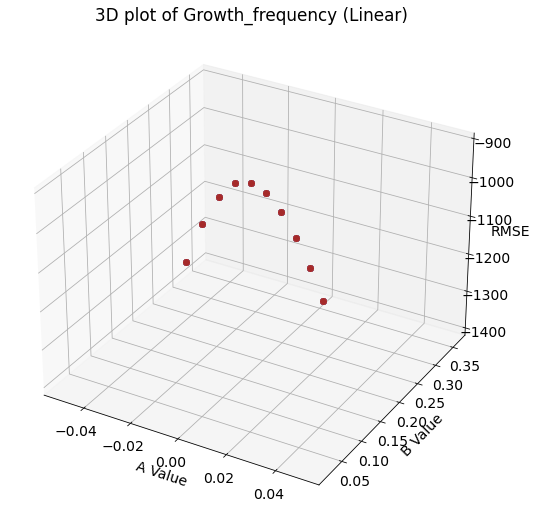

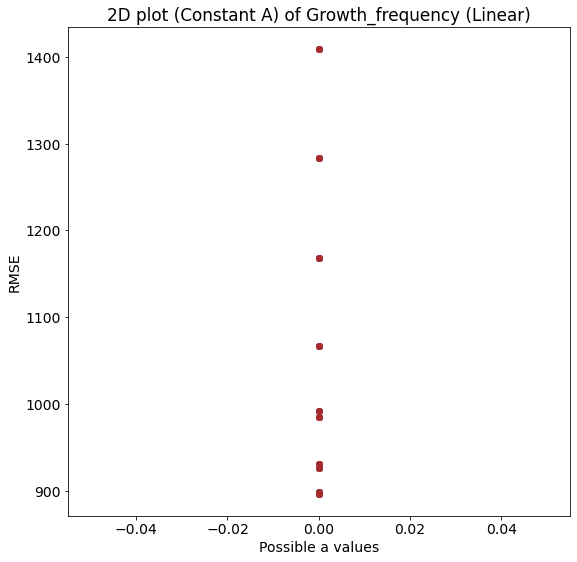

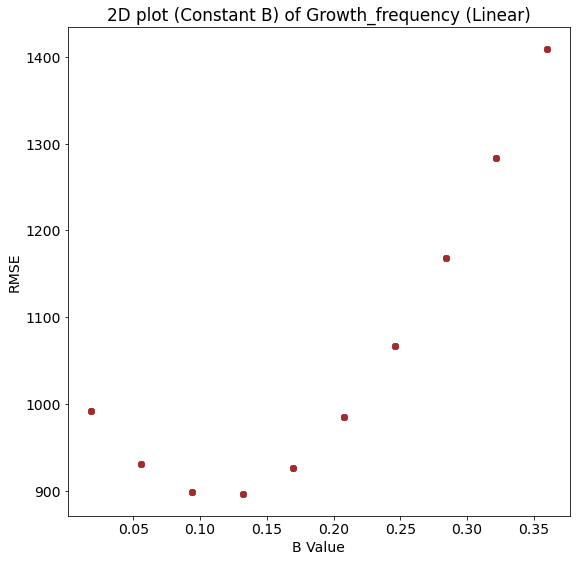

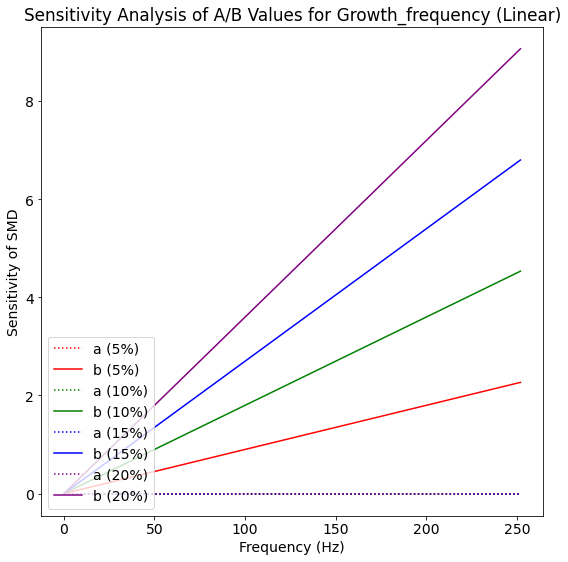

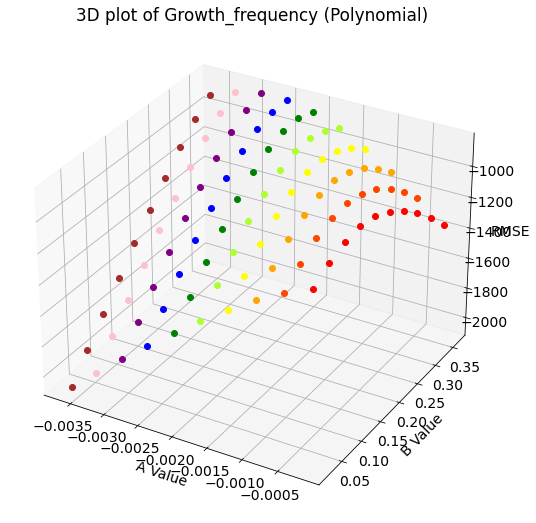

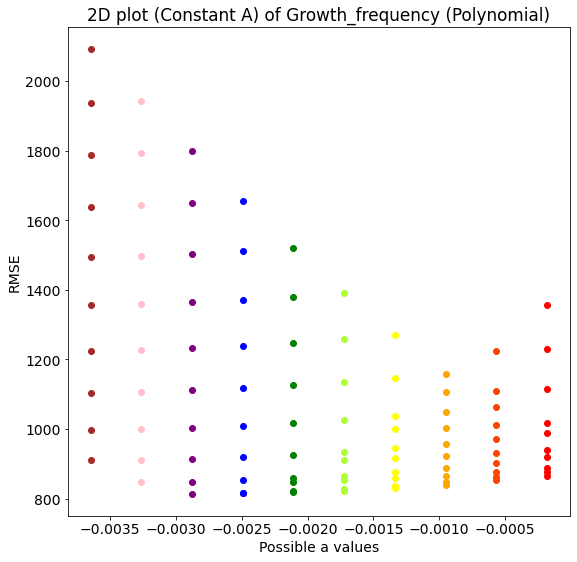

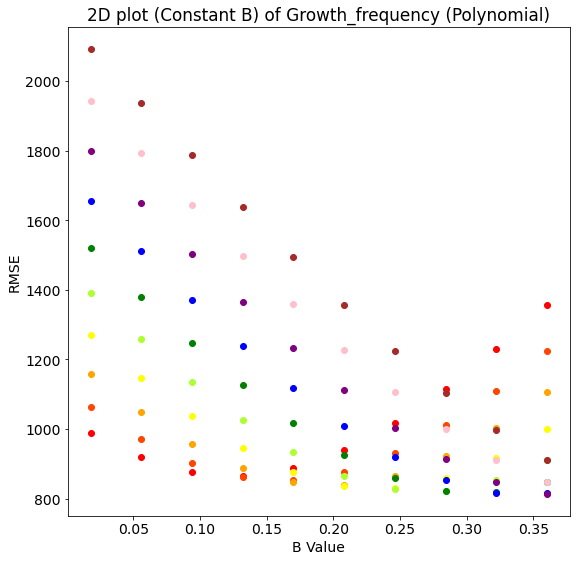

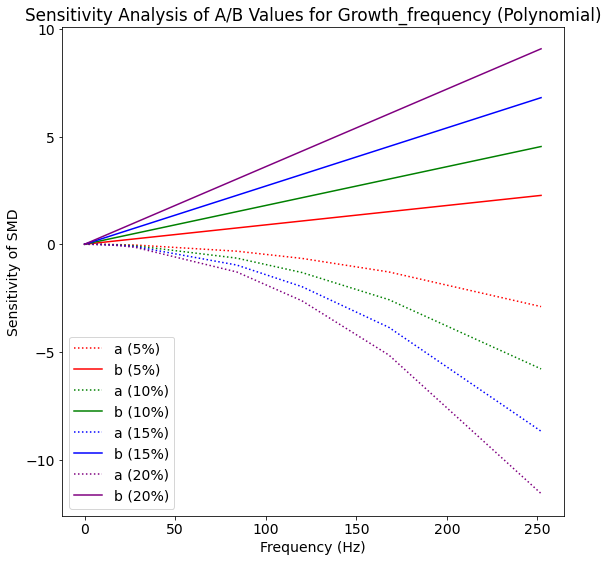

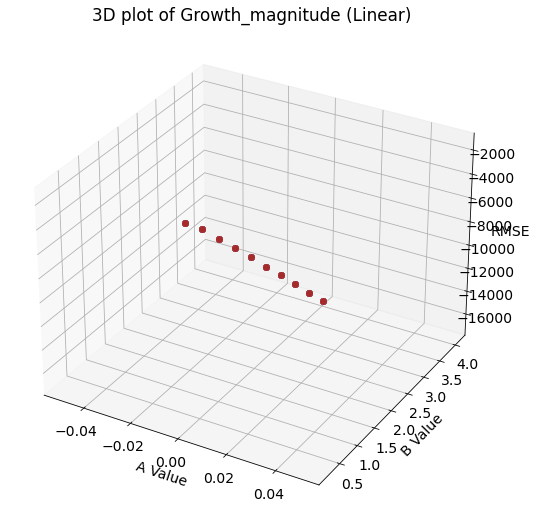

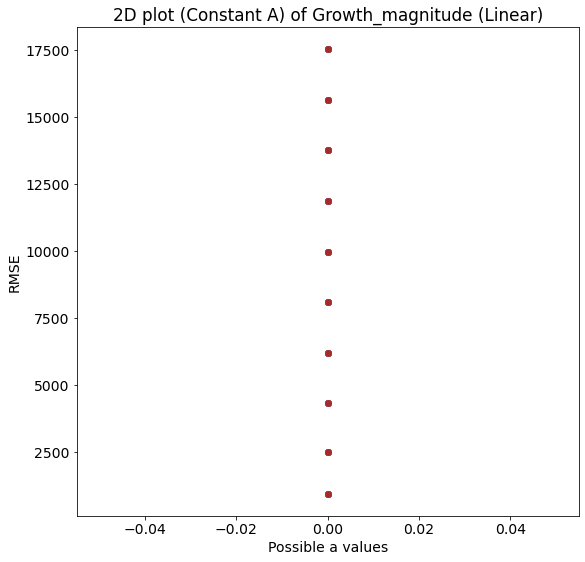

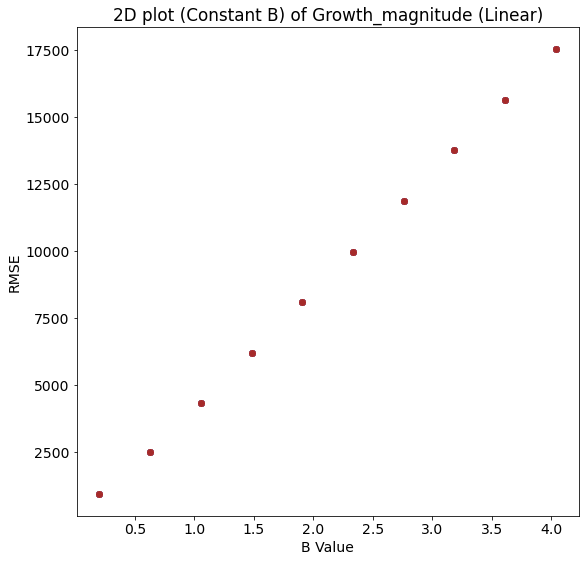

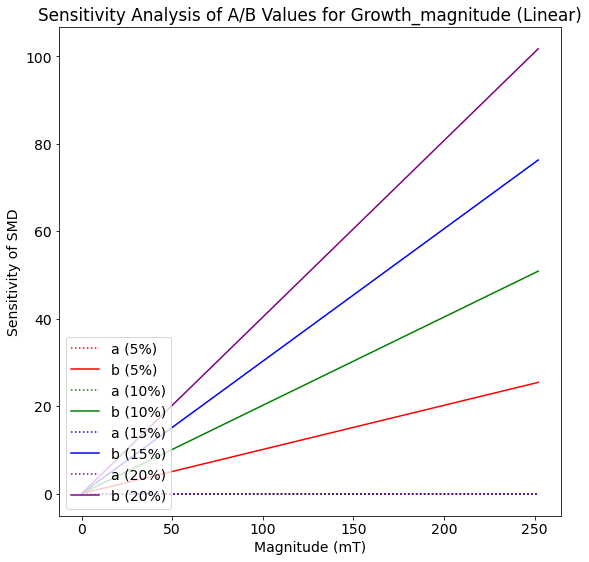

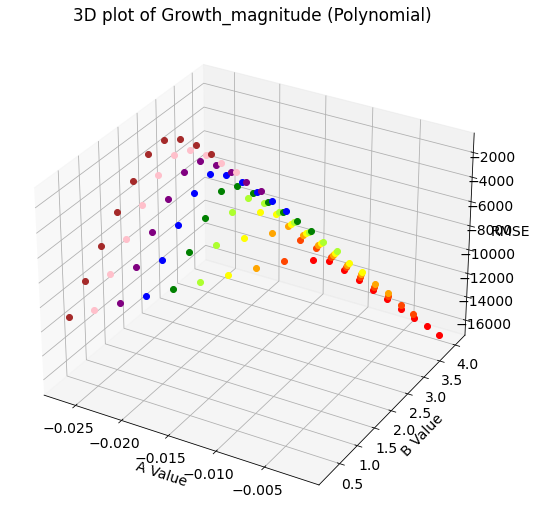

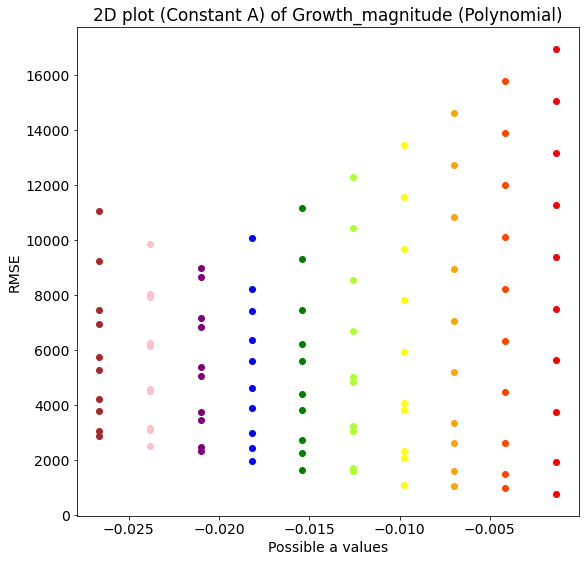

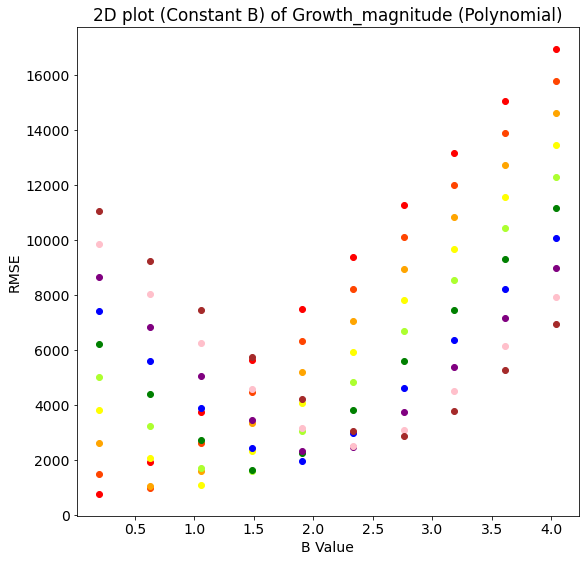

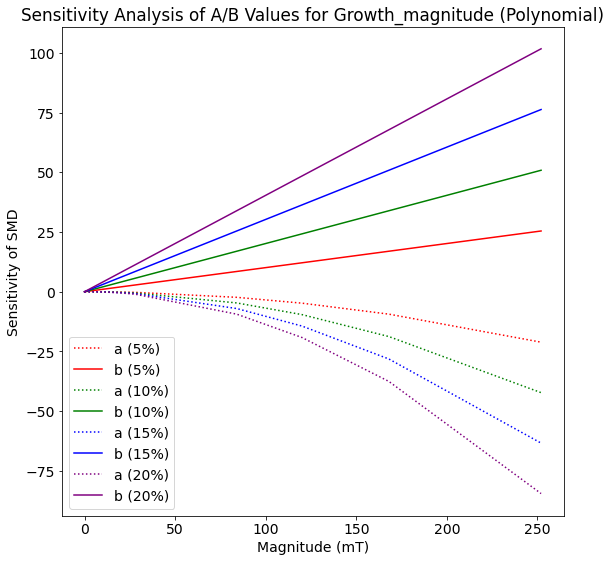

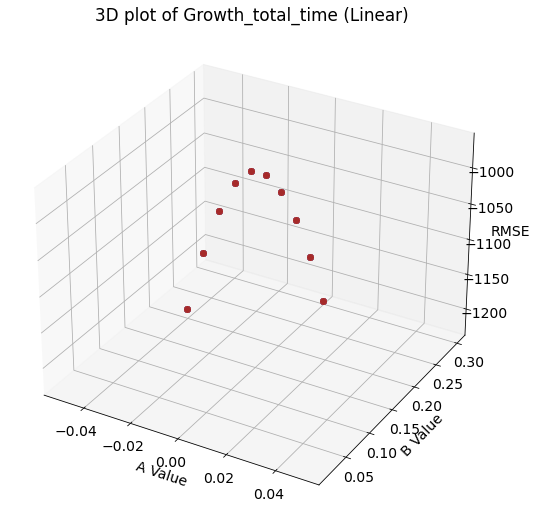

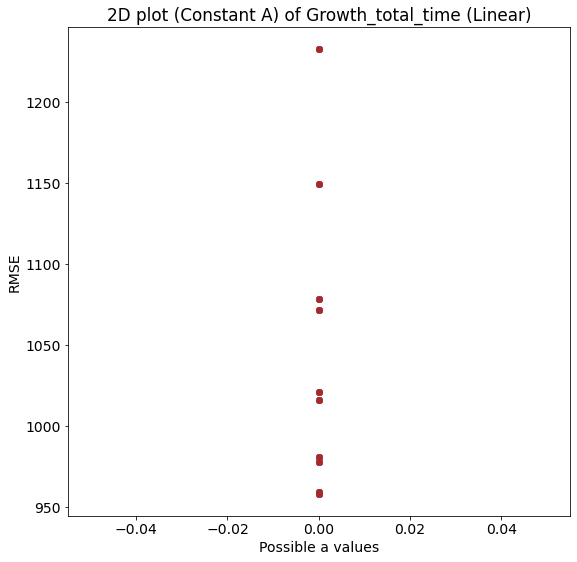

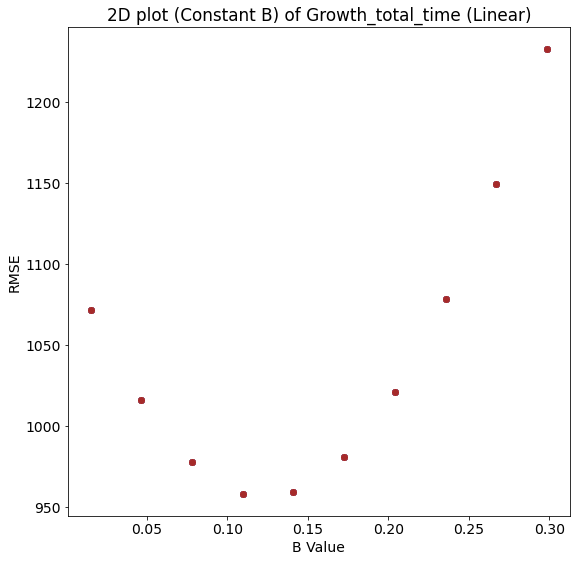

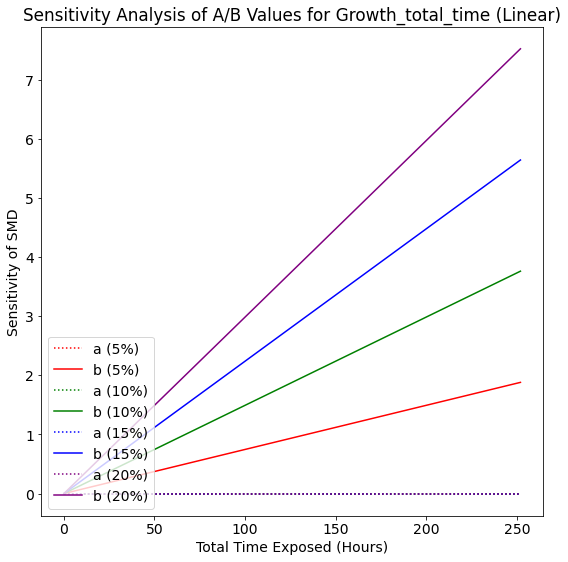

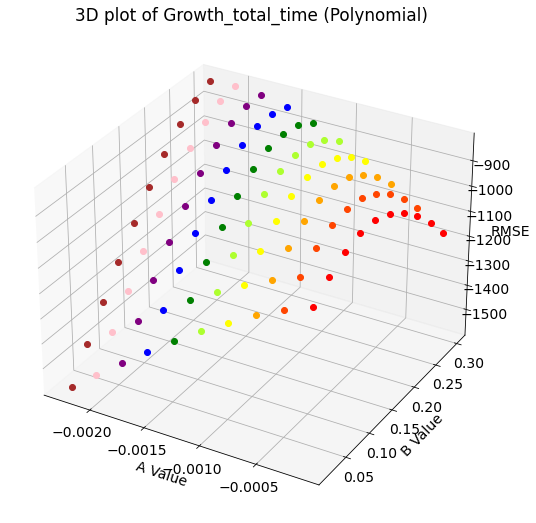

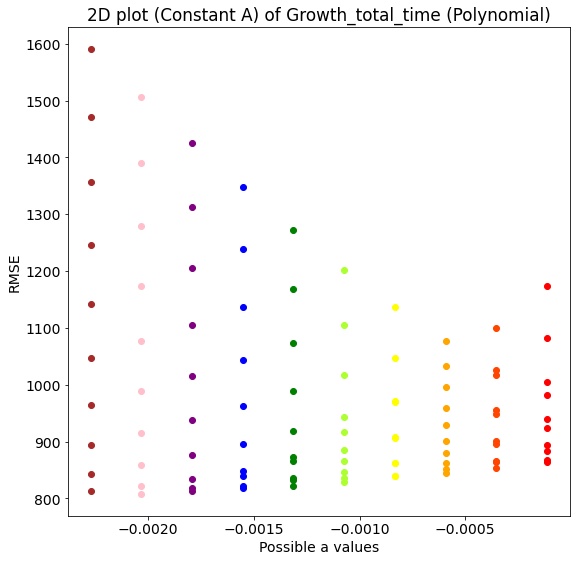

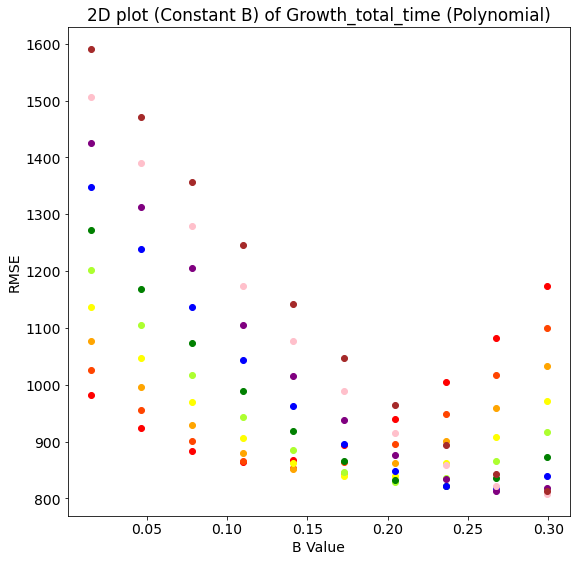

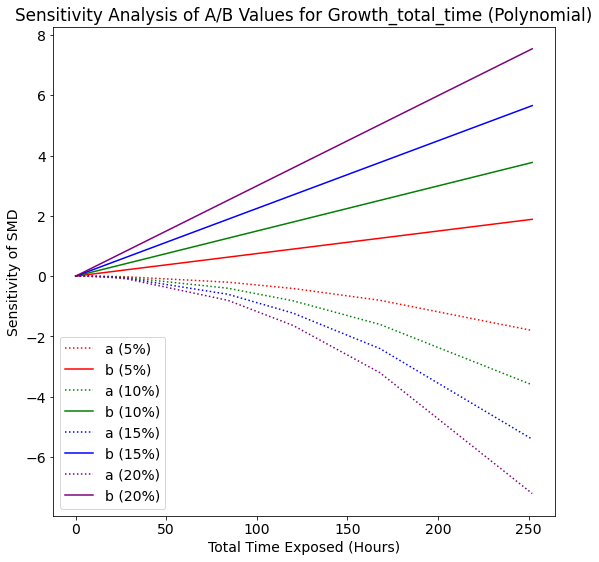

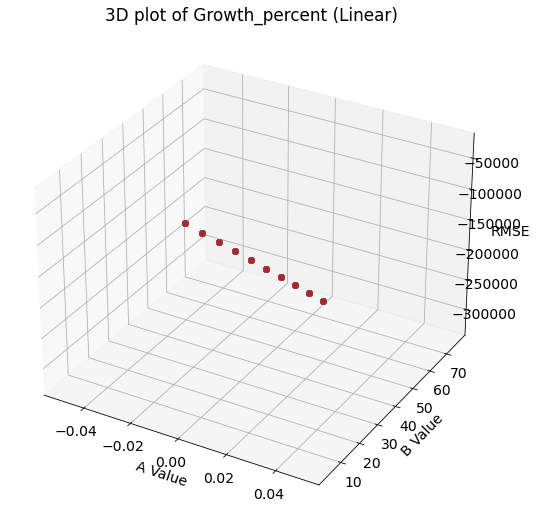

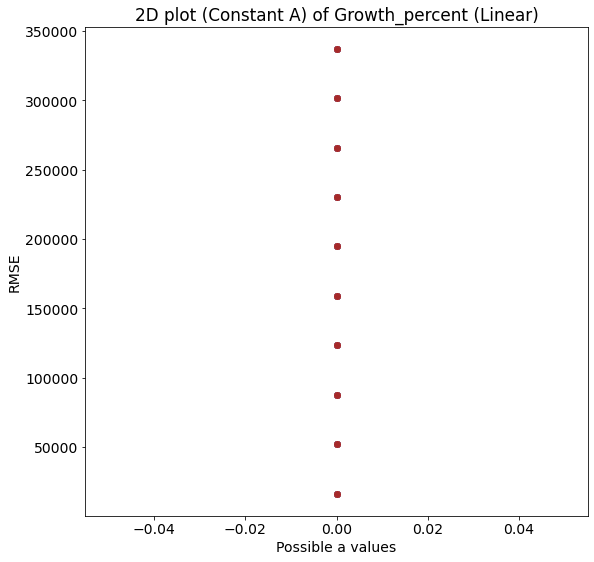

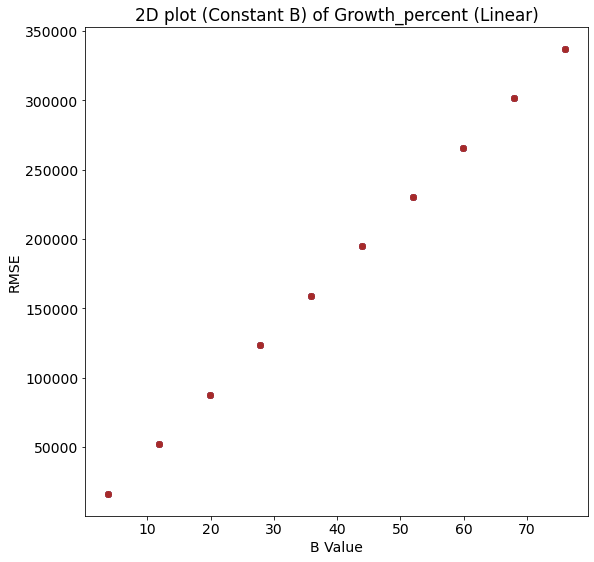

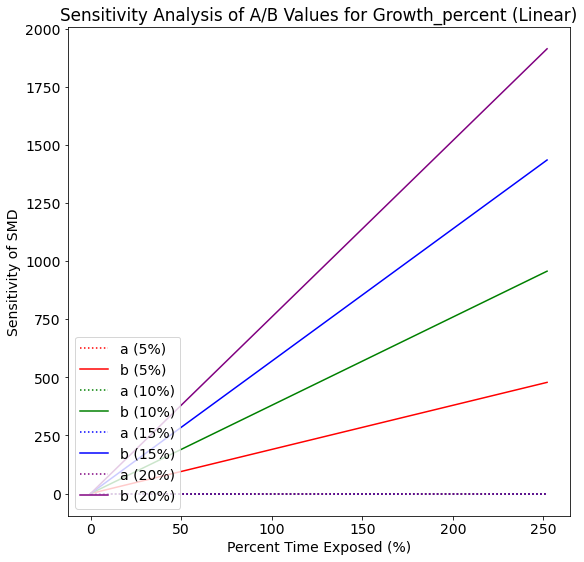

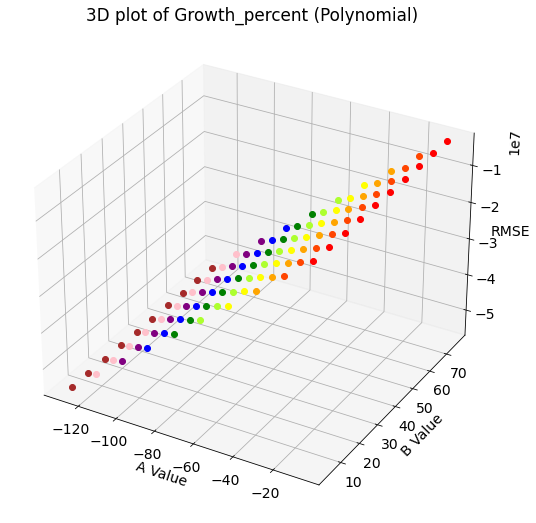

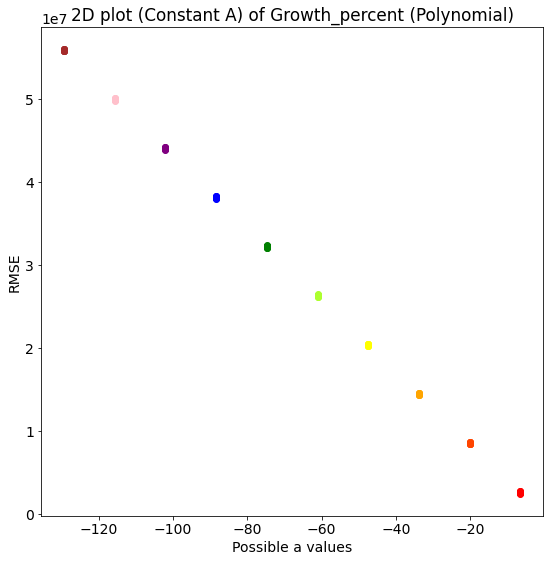

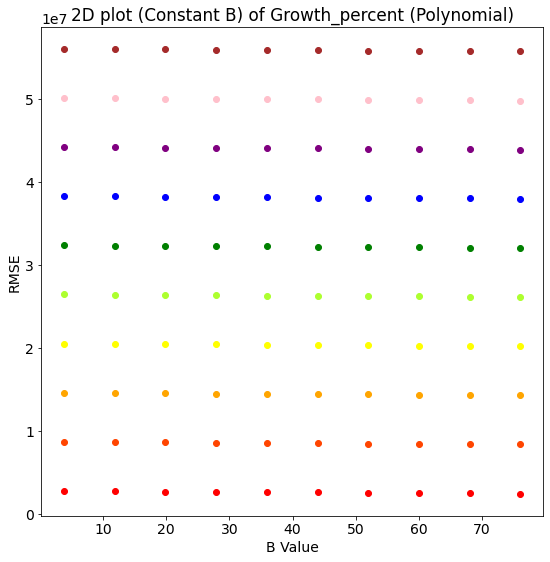

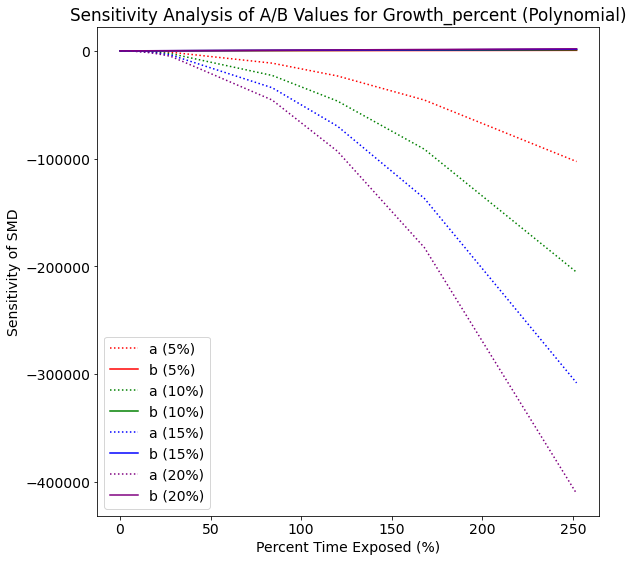

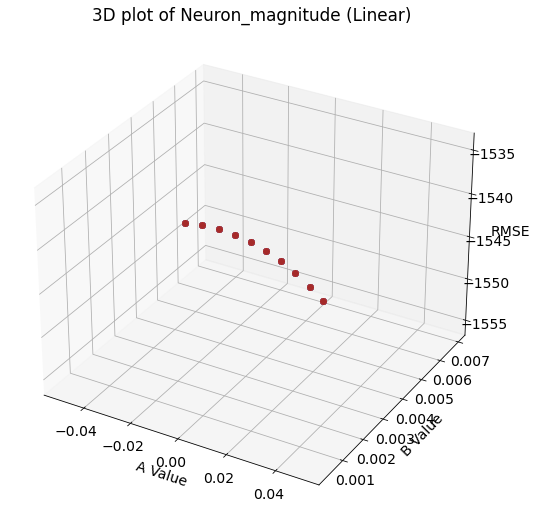

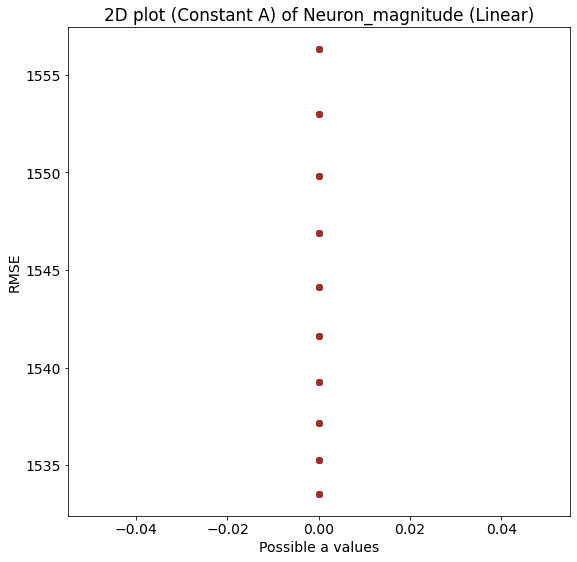

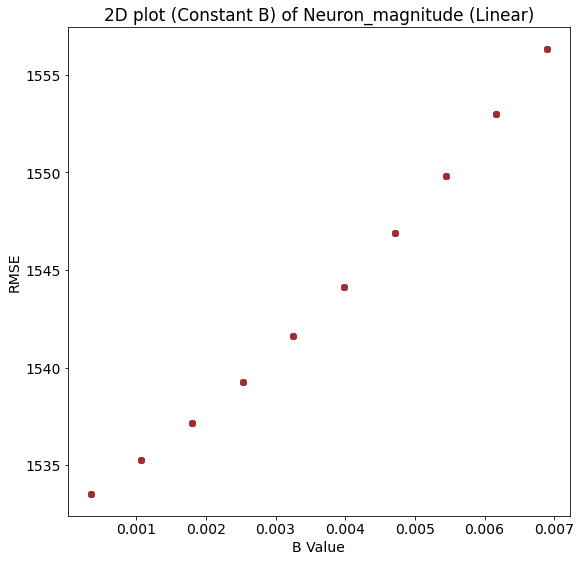

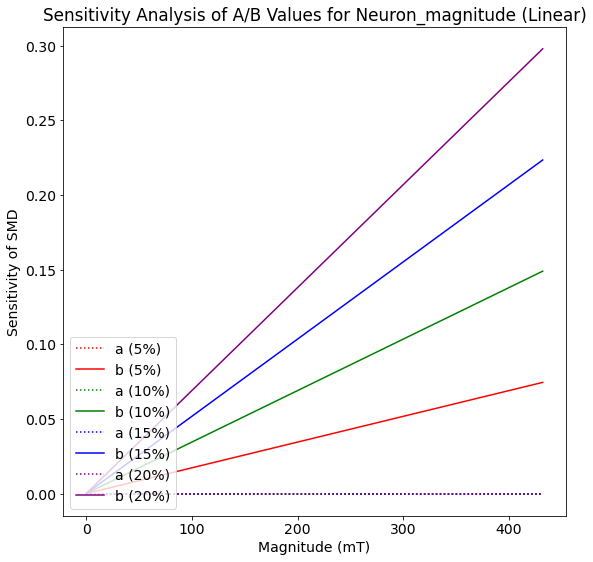

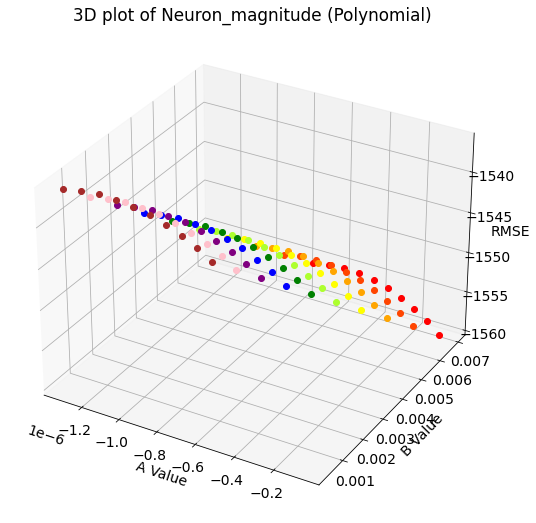

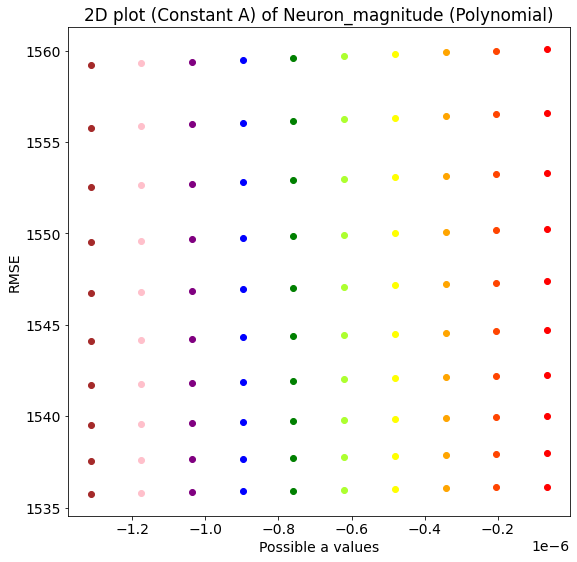

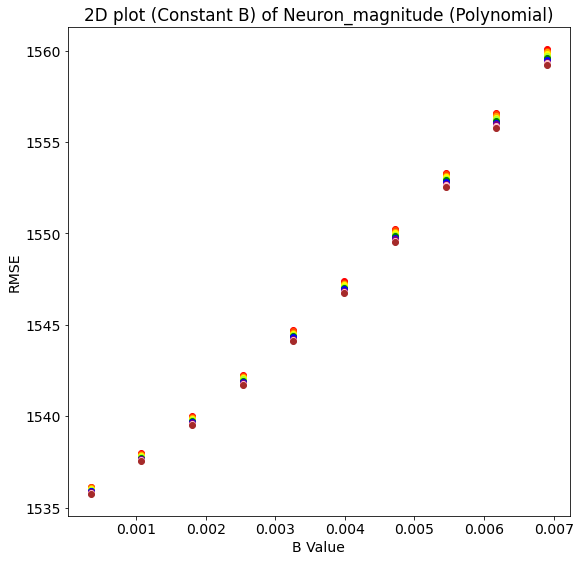

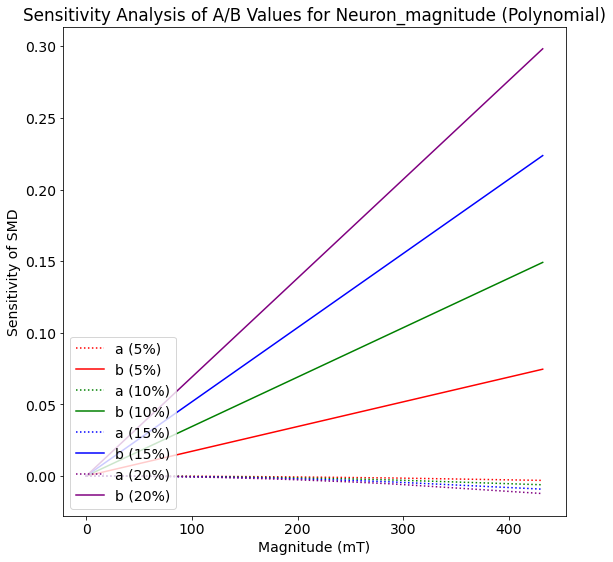

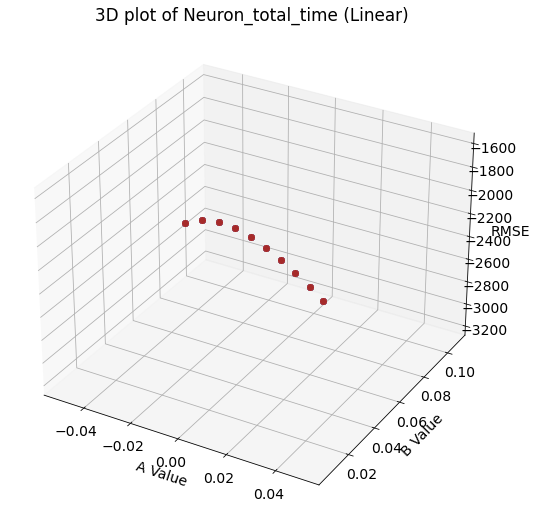

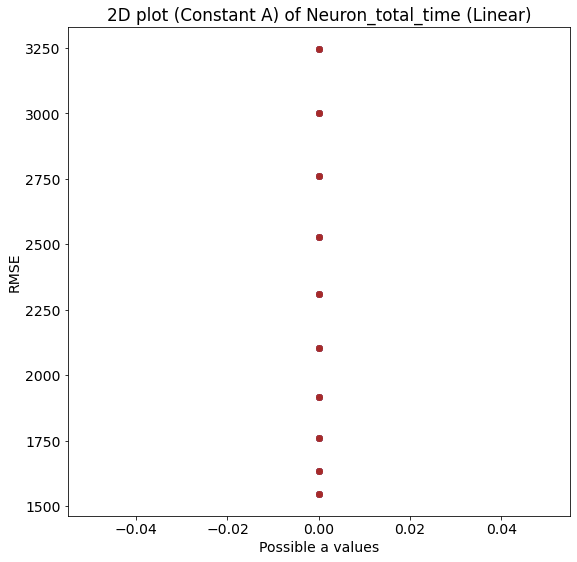

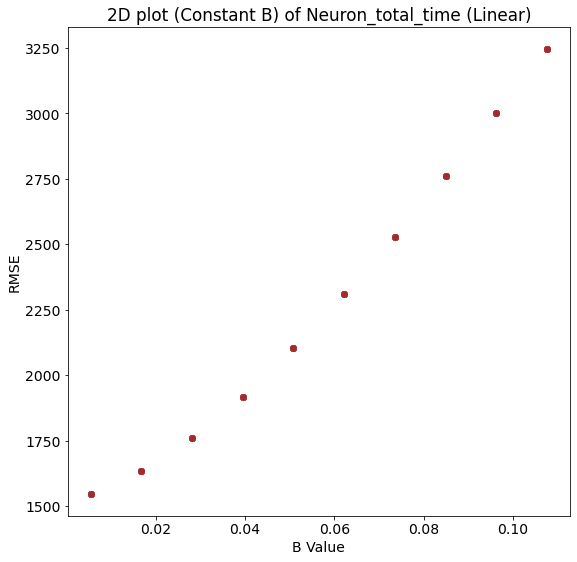

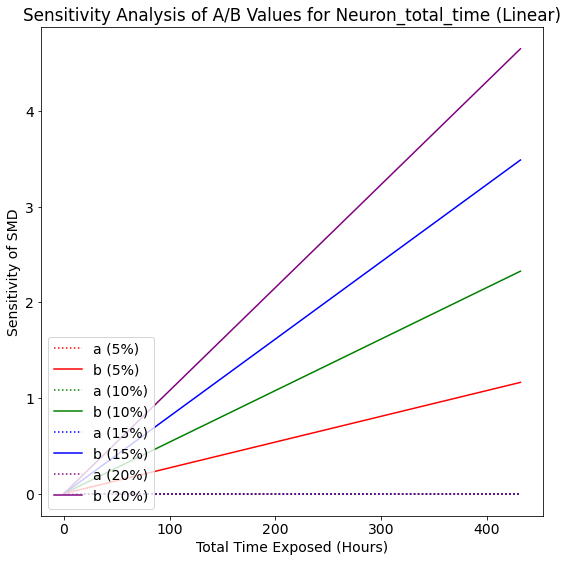

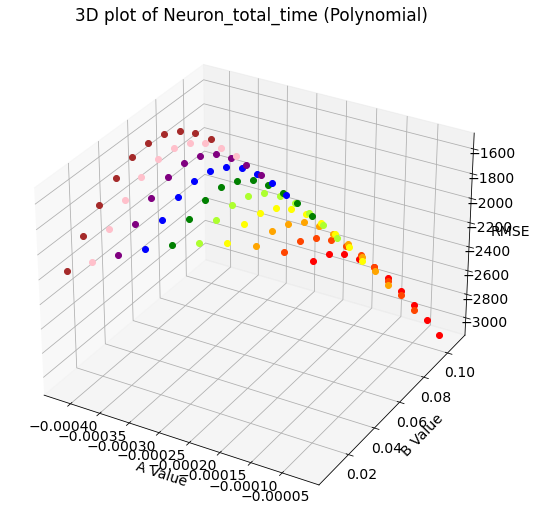

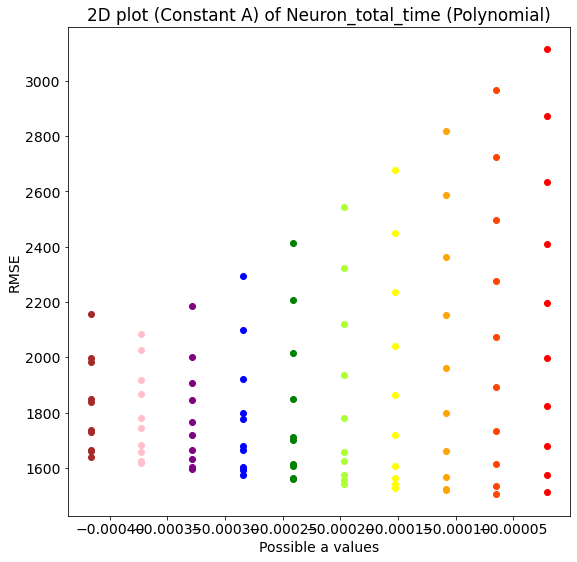

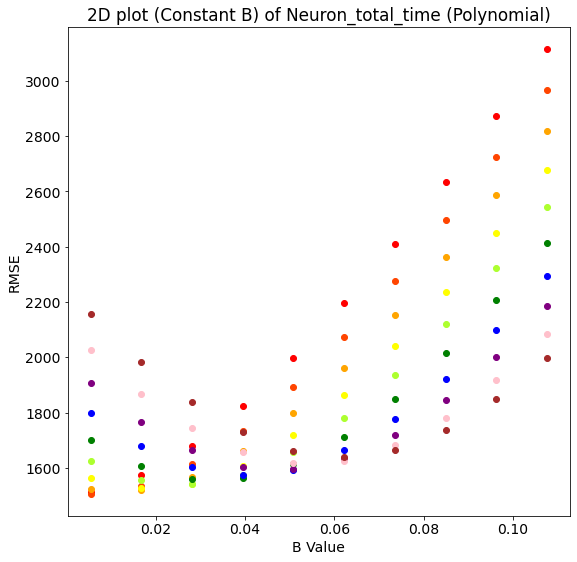

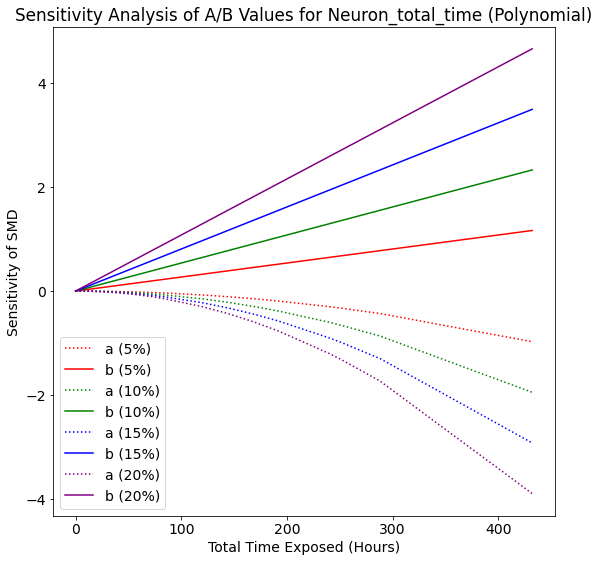

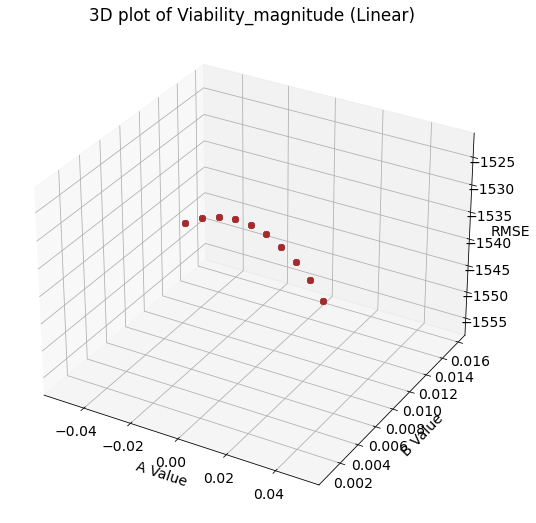

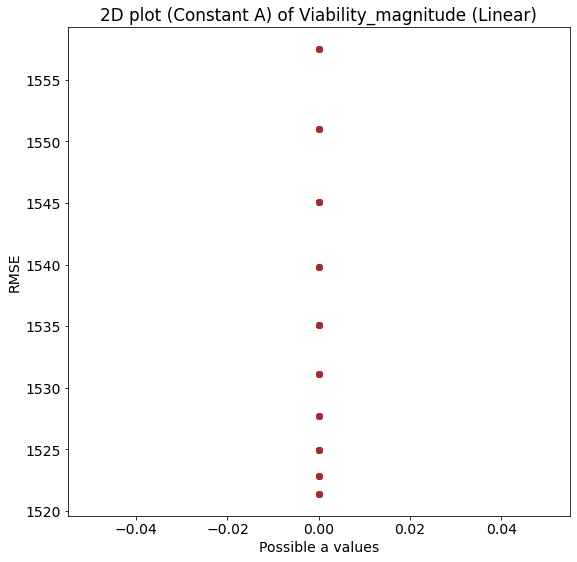

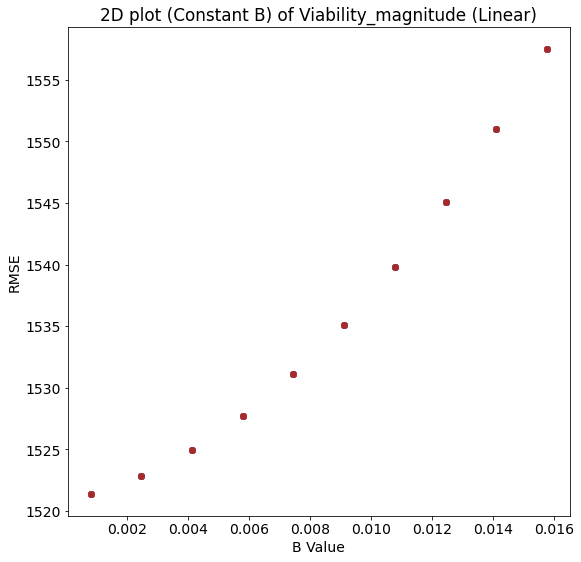

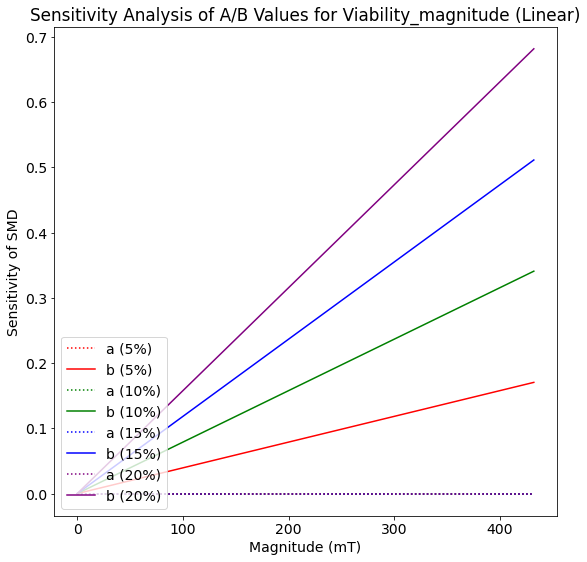

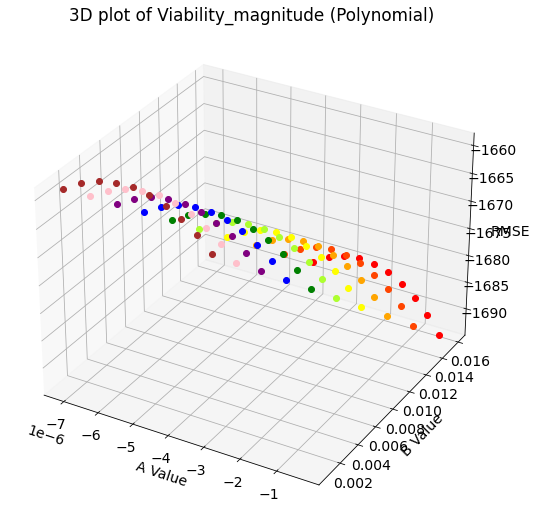

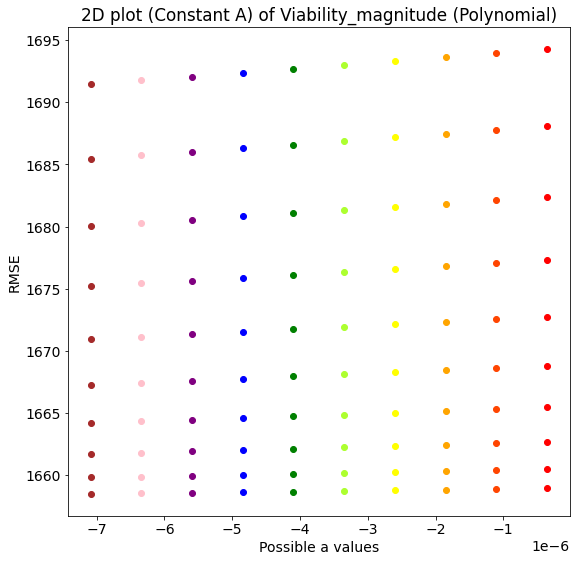

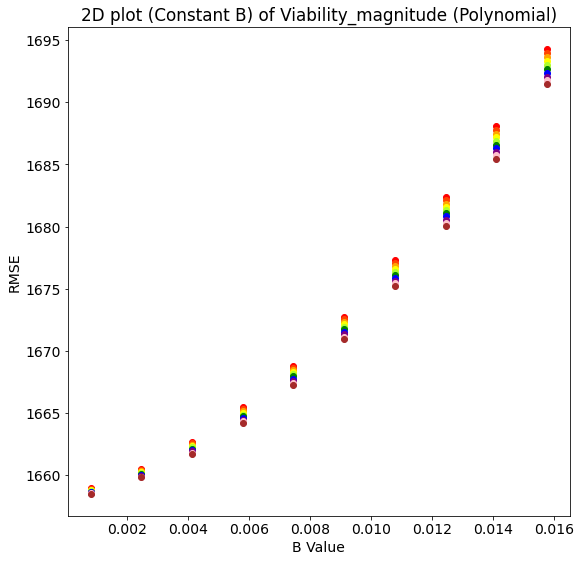

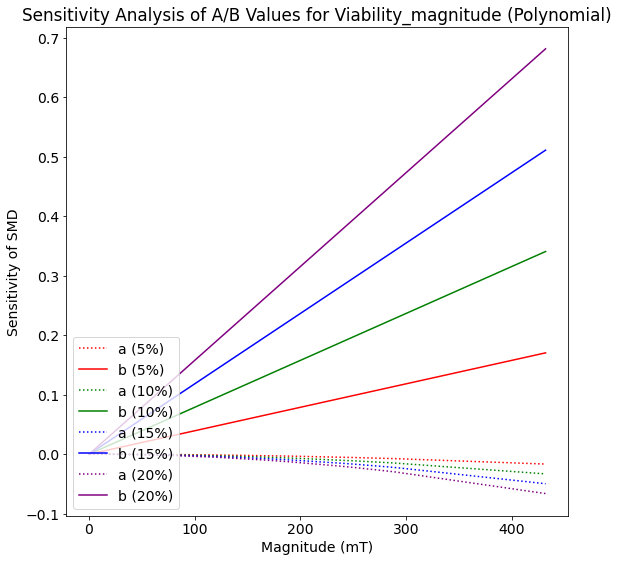

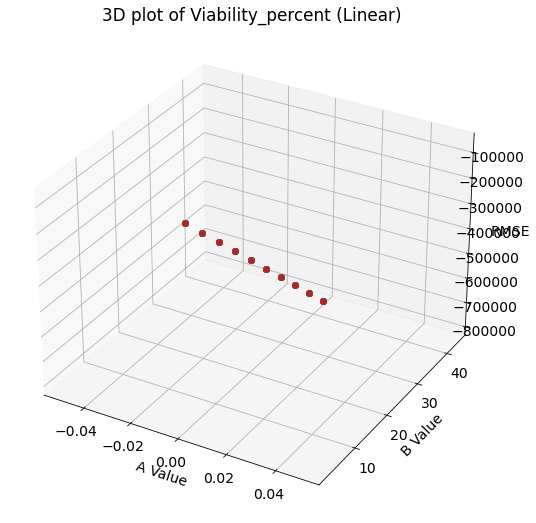

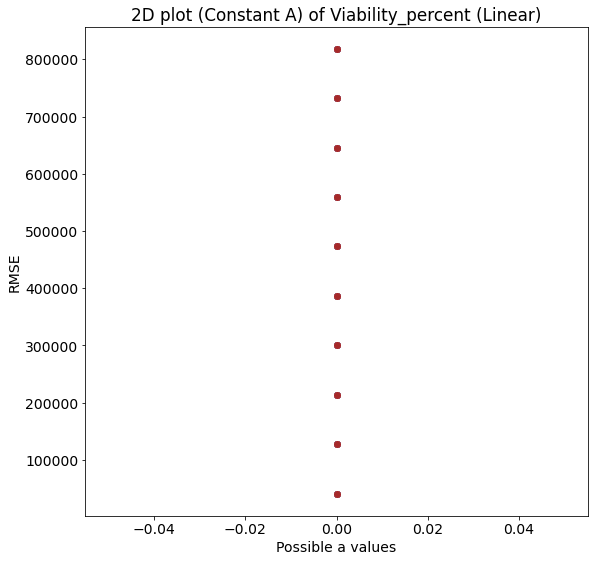

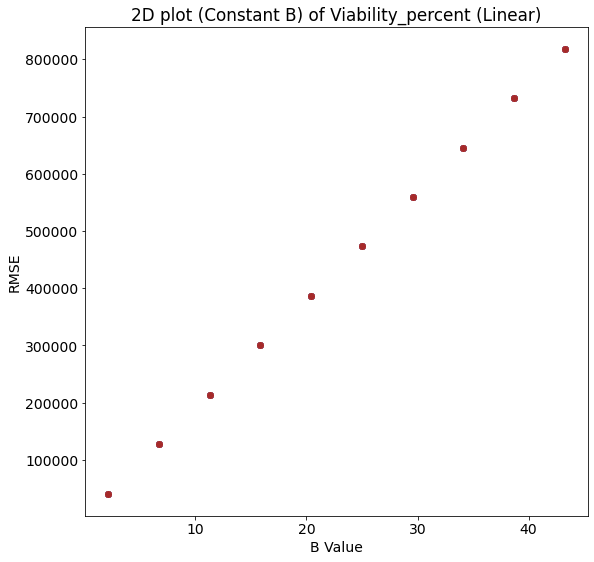

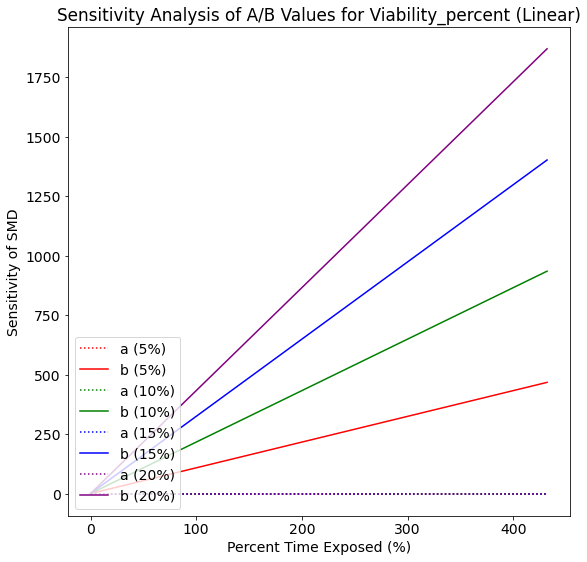

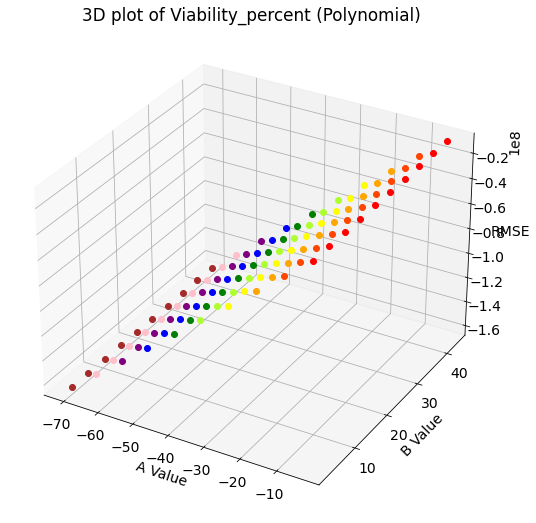

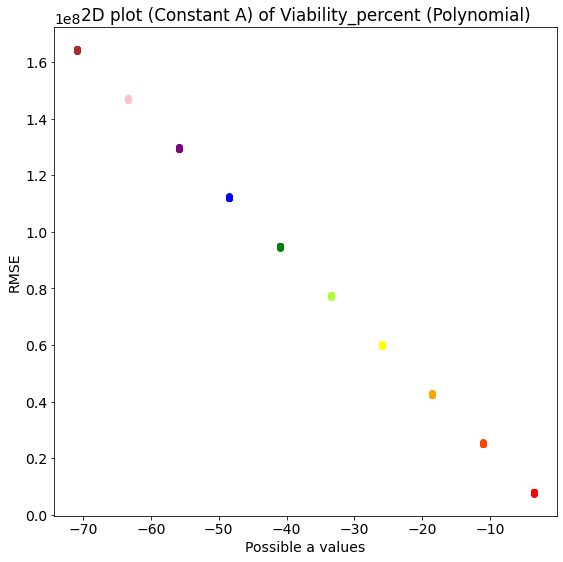

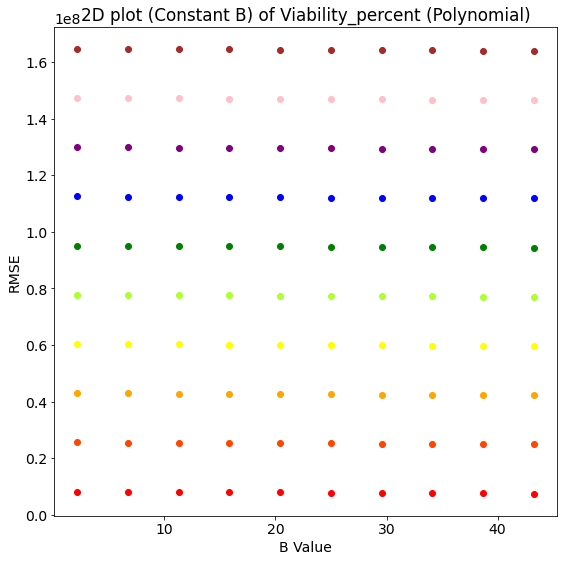

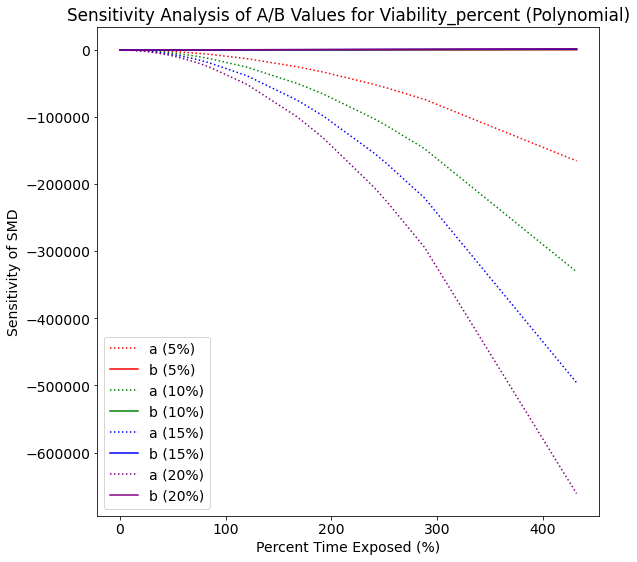

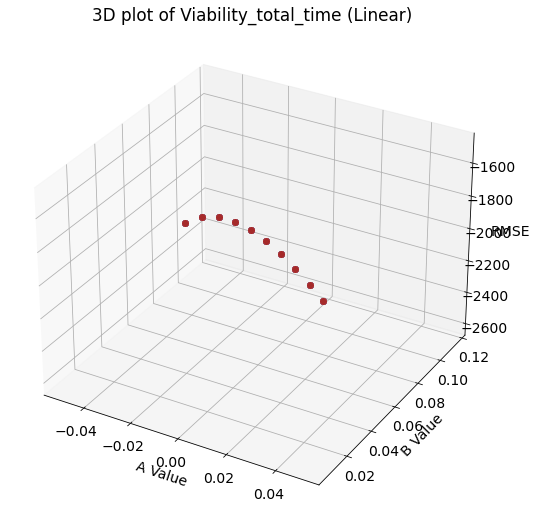

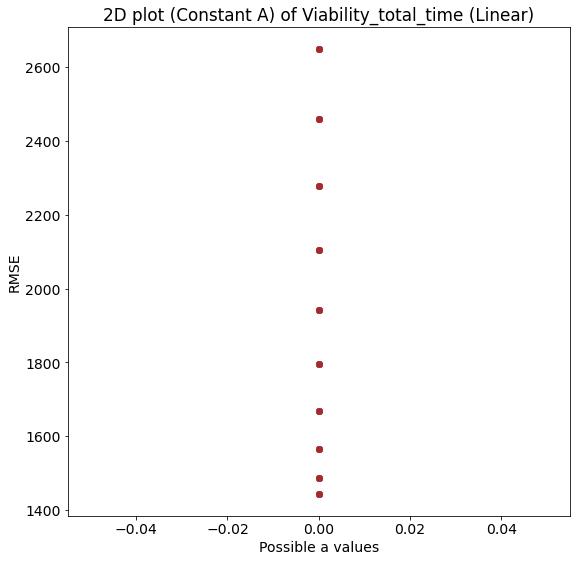

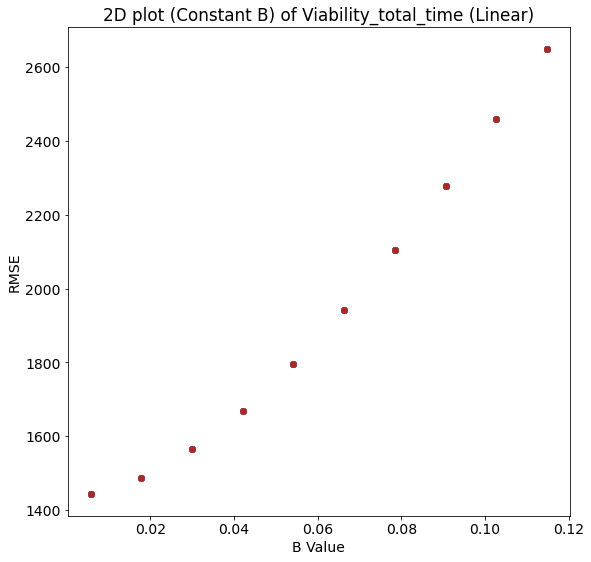

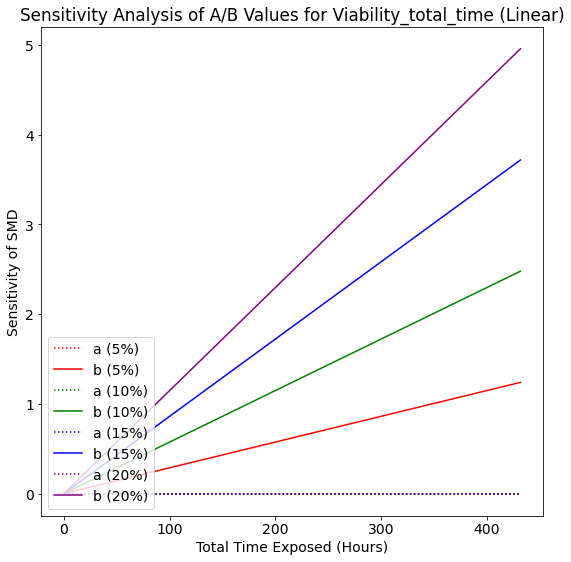

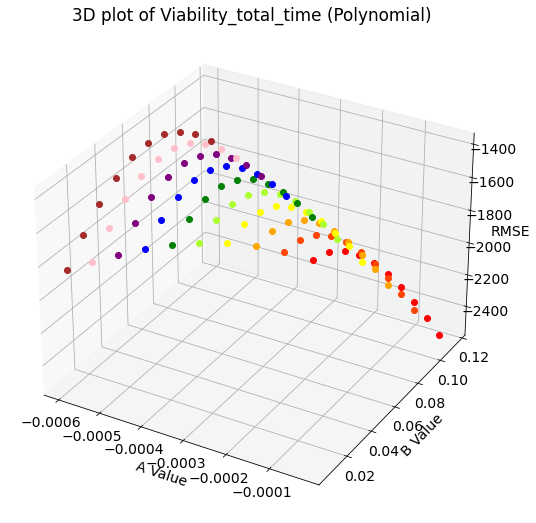

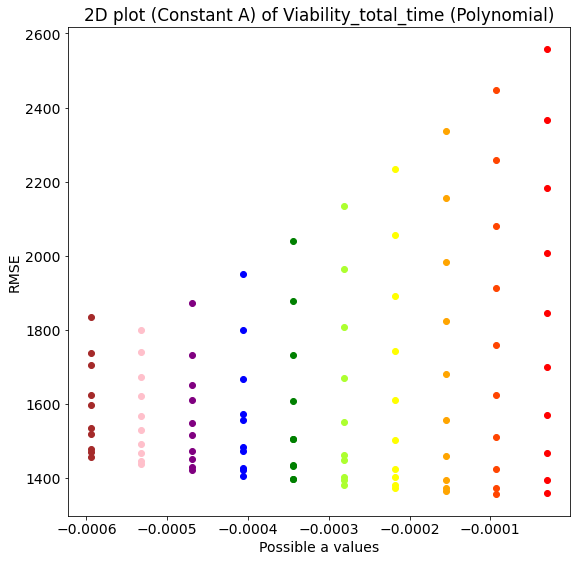

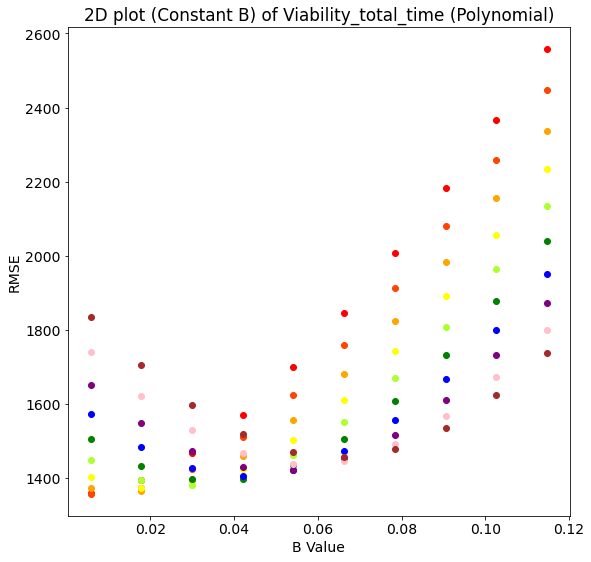

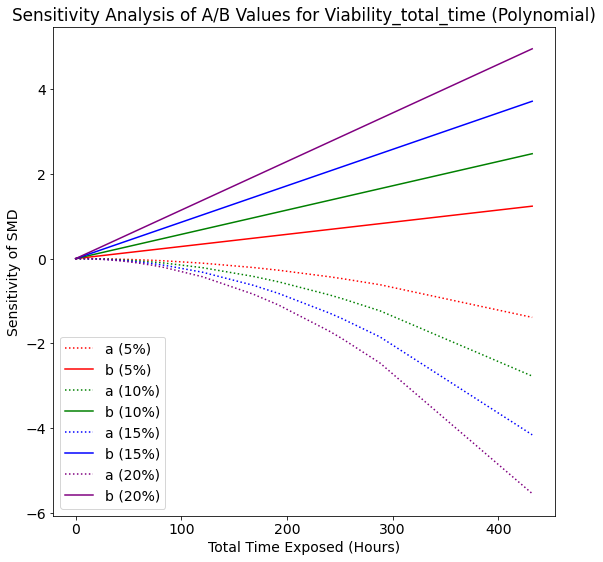

In [14]:


filepath = 'Final_data/p_values/'

#items of interest
#fill in 
#lst = ['viability_Neural_magnitude', 'regeneration_Neural_frequency', 'proliferation_Neural_magnitude']

#add back in 'Linear' to choice
lst = ['Growth_frequency',\
       'Growth_magnitude', \
       'Growth_total_time',\
       'Growth_percent', \
       'Neuron_magnitude',\
       'Neuron_total_time',\
       'Viability_magnitude',\
       'Viability_percent',\
       'Viability_total_time']

sen = [['Group', 'Linear/Polynomial', 'a value at 20%', 'b value at 20%']]

for group in lst:
    for choice in ['Linear','Polynomial']:
        file = filepath + group + "_" + choice + '.csv'
        print(file)
        with open(file) as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=',')
            rows = list(csv_reader)
        a_value = float(rows[1][1])
        b_value = float(rows[2][1])
        RMSE_vs_a_b(a_value, b_value)
        r = sensitivity_a_b(a_value, b_value)
        sen.append([group] + [choice] + [r[0]] + [r[1]])
        
        
#write the accumulated file
with open("Last_value.csv", "w", newline='') as f:
    writer = csv.writer(f,delimiter=',')
    writer.writerows(sen)